# Previsão cenário Covid-19 Rio de Janeiro - Modelo SIR Extendido para incerteza de dados - Gilberto Ramos.

Referências:

https://arxiv.org/pdf/2106.08048.pdf

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3710332/

https://covid19datahub.io/



**Simulação de previsão com parametros iniciais já encontrados e dataset no período de 04.04.20 a 04.12.21 com epidemic_start_day_ago=30**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Insert the directory
import sys
sys.path.insert(0,'/content/drive/My Drive/ColabNotebooks')

In [1]:
!pip install lmfit #O método Levenberg-Marquardt através da biblioteca Lmfit foi usado para otimização.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 292 kB 5.2 MB/s 
     |████████████████████████████████| 98 kB 3.2 MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.3-py3-none-any.whl size=84411 sha256=e727002dbad2301fb905328d2f3dad259937e9e5566a6518fc7937bb23657aa9
  Stored in directory: /root/.cache/pip/wheels/b9/7a/d1/236aa0f8196b264fda481a112f7cfb1bfde7bfb20235f8e331
Successfully built lmfit


In [2]:
!pip install datatest  #suporte para pré-processamento de dados

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 141 kB 4.3 MB/s 


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error
import lmfit
from tqdm.auto import tqdm
import pickle
import joblib
import matplotlib.dates as mdates
#tratar outliers
from statistics import median
from datatest import validate
from datatest.requirements import adapts_mapping
from datatest.requirements import RequiredInterval

In [4]:
sns.set()
#%matplotlib inline

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

In [7]:
#sns.set_context("talk")
#sns.set_style("ticks")

In [7]:
sns.set_context("paper")
sns.set_style("ticks")

# Load data

Carregar os arquivos do diretório: C:\Users\xzco\OneDrive - PETROBRAS\Documents\GitHub\covid_peak_sir_modelling\sir_models
para o 'content/drive' do google drive p/ ser acessado pelo Colab. 

In [ ]:
from google.colab import files  #utils.py
files.upload()

#C:\Users\xzco\OneDrive - PETROBRAS\Documents\GitHub\covid_peak_sir_modelling\sir_models

In [ ]:
from google.colab import files #models_v3_txVac.py
files.upload()

In [11]:
#from google.colab import files #models2.py
#files.upload()

In [ ]:
from google.colab import files #fitters3.py
files.upload()

In [11]:
from google.colab import files
files.upload()

Saving __init__.py to __init__.py


{'__init__.py': b''}

**importar os arquivos carregados (esses arquivos .py contém as classes e métodos que vamos usar)**

In [12]:
import models_v3_txVac # com vacinacao
#import models2

In [13]:
import fitters3

#dfRJ - Dados RJ 04.04.20 a 04.12.21 - ( epidemic_started_days_ago=30 )

In [14]:
#testando aqui dfRJ - dados RJ
from google.colab import files 
uploaded = files.upload()
dfRJ = pd.read_csv('dfRJ_04abr20_a_04dez21_v1.csv', sep=';') # esse file está na pasta Downloads

#linha abaixo usada para inicialização de parâmetros e ajuste da curva
#dfRJ = pd.read_csv('dfRJ_04abr20_a_04out20_ok.csv', sep=';') # esse file está na pasta Downloads


Saving dfRJ_04abr20_a_04dez21_v1.csv to dfRJ_04abr20_a_04dez21_v1.csv


In [15]:
dfRJ.head()

,date,total_infectados,total_recuperados,total_mortos,mortos_por_dia,infectados_por_dia,recuperados_por_dia,vacinados_por_dia,total_pessoas_vacinadas,total_pessoas_completamente_vacinadas
0,04.04.2020,1246,1,58,6,148,0,0,0,0
1,05.04.2020,1394,1,64,6,148,0,0,0,0
2,06.04.2020,1461,1,71,7,67,0,0,0,0
3,07.04.2020,1688,1,89,18,227,0,0,0,0
4,08.04.2020,1938,183,106,17,250,182,0,0,0


In [16]:
dfRJ.tail()

,date,total_infectados,total_recuperados,total_mortos,mortos_por_dia,infectados_por_dia,recuperados_por_dia,vacinados_por_dia,total_pessoas_vacinadas,total_pessoas_completamente_vacinadas
605,30.11.2021,1343927,1251766,69061,34,1126,0,34959,13360055,10662768
606,01.12.2021,1344816,1274186,69082,21,889,6939,95,13360150,10670528
607,02.12.2021,1345572,1274186,69102,20,756,0,7783,13367933,10713965
608,03.12.2021,1346494,1274186,69124,22,922,0,0,13367933,10713965
609,04.12.2021,1346998,1274186,69132,8,504,0,88,13368021,10815018


***Tratamento de Outliers com Método Tukey***

Em “Exploratory Data Analysis” de John W. Tukey (1977), foi proposto um multiplicador de 1,5 para rotular outliers e 3,0 para rotular outliers “distantes”. O multiplicador padrão de 2.2 é baseado em “Ajuste fino de algumas regras resistentes para rotulagem de valores atípicos” de Hoaglin e Iglewicz (1987).

In [ ]:
def median(iterable):
    values = sorted(iterable)
    n = len(values)
    if n == 0:
        raise ValueError('no median for empty iterable')
    i = n // 2
    if n % 2 == 1:
        return values[i]
    return (values[i - 1] + values[i]) / 2.0

In [ ]:
#tratamento de outliers - método tukey
@adapts_mapping
class RequiredOutliers(RequiredInterval):
    """Require that data does not contain outliers."""
    def __init__(self, values, multiplier=2.2):
        values = sorted(values)

        if len(values) >= 2:
            midpoint = int(round(len(values) / 2.0))
            q1 = median(values[:midpoint])
            q3 = median(values[midpoint:])
            iqr = q3 - q1
            lower = q1 - (iqr * multiplier)
            upper = q3 + (iqr * multiplier)
        elif values:
            lower = upper = values[0]
        else:
            lower = upper = 0

        super().__init__(lower, upper)

In [ ]:
#def removeoutlier(values):                     #define a função com uma variavel de entrada
#    fator = 1.5                                #1.5 é o fator de multiplicacao
#    q75, q25 = np.percentile(values, [75, 25]) #retorna o terceiro e primeiro quartil
#    iqr = q75 - q25                            #calcula o iqr(interquartile range)

#    lowpass = q25 - (iqr * fator)              #calcula o valor minimo para aplicar no filtro
#    highpass = q75 + (iqr * fator)             #calcula o valor maximo para aplicar no filtro

#    outliers = np.argwhere(values < lowpass)   #descobre onde estao os valores menores que o valor minimo
#    values = np.delete(values, outliers)       #deleta esses valores

#    outliers = np.argwhere(values > highpass)  #descobre onde estao os valores maiores que o valor maximo
#    values = np.delete(values, outliers)       #deleta esses valores

#    return values                              #retorna a variavel sem outliers




# tratamento de dados

In [16]:
dfRJ.columns = ['date', 'total_infectados',	'total_recuperados',	'total_mortos',	'mortos_por_dia',	'infectados_por_dia', 'recuperados_por_dia','vacinados_por_dia', 'total_pessoas_vacinadas',	'total_pessoas_completamente_vacinadas']
dfRJ['date'] = pd.to_datetime(dfRJ['date'], format='%d.%m.%Y')
dfRJ = dfRJ.sort_values(by='date')
dfRJ.head()

,date,total_infectados,total_recuperados,total_mortos,mortos_por_dia,infectados_por_dia,recuperados_por_dia,vacinados_por_dia,total_pessoas_vacinadas,total_pessoas_completamente_vacinadas
0,2020-04-04,1246,1,58,6,148,0,0,0,0
1,2020-04-05,1394,1,64,6,148,0,0,0,0
2,2020-04-06,1461,1,71,7,67,0,0,0,0
3,2020-04-07,1688,1,89,18,227,0,0,0,0
4,2020-04-08,1938,183,106,17,250,182,0,0,0


In [19]:
dfRJ.tail()

,date,total_infectados,total_recuperados,total_mortos,mortos_por_dia,infectados_por_dia,recuperados_por_dia,vacinados_por_dia,total_pessoas_vacinadas,total_pessoas_completamente_vacinadas
605,2021-11-30,1343927,1251766,69061,34,1126,0,34959,13360055,10662768
606,2021-12-01,1344816,1274186,69082,21,889,6939,95,13360150,10670528
607,2021-12-02,1345572,1274186,69102,20,756,0,7783,13367933,10713965
608,2021-12-03,1346494,1274186,69124,22,922,0,0,13367933,10713965
609,2021-12-04,1346998,1274186,69132,8,504,0,88,13368021,10815018


In [ ]:
#verificação de outliers por coluna

#data = [54, 44, 42, 46, 87, 48, 56, 52]  # <- 87 is an outlier
data = dfRJ['infectados_por_dia']
requirement = RequiredOutliers(data, multiplier=2.2)
validate(data, requirement)



In [ ]:
#data = [54, 44, 42, 46, 87, 48, 56, 52]  # <- 87 is an outlier
data = dfRJ['mortos_por_dia']
requirement = RequiredOutliers(data, multiplier=2.2)
validate(data, requirement)

In [ ]:
#data = [54, 44, 42, 46, 87, 48, 56, 52]  # <- 87 is an outlier
data = dfRJ['recuperados_por_dia']
requirement = RequiredOutliers(data, multiplier=2.2)
validate(data, requirement)

In [ ]:
data = dfRJ['total_mortos']
requirement = RequiredOutliers(data, multiplier=2.2)
validate(data, requirement)

In [ ]:
data = dfRJ['total_infectados']
requirement = RequiredOutliers(data, multiplier=2.2)
validate(data, requirement)

In [ ]:
data = dfRJ['total_recuperados']
requirement = RequiredOutliers(data, multiplier=2.2)
validate(data, requirement)

In [ ]:
#print a                #imprime a variavel com outliers

a = np.array(dfRJ['infectados_por_dia'])
#print(a)
removeoutlier(a)

array([ 148,  148,   67,  227,  250,  278,  248,  143,  248,  376,  179,
        333,  201,  405,  194,  222,  134,  407,  246,  620,  110,  546,
        283,  833,  560,  365,  584,  713,  380,  593,  582,  670,  904,
        861, 1585, 1188,  133,  877,  547,  242,  739,  520, 1614,  637,
       4427, 1140, 2567, 1717, 1500,  944, 3379, 1386,  726, 2374, 2488,
       3067, 4467,  968, 1142, 2202, 2508, 1692, 2134, 1467, 3223, 1743,
       3480, 1394, 1402, 2009, 1052,  736, 1374, 2397, 3620,  354, 6061,
       2159,  596, 1439, 3297, 2624, 2404, 2600,  306, 2495,  585,  728,
       2667, 1545, 2133, 1484,  852,  587, 2207, 2243, 1995, 1119,  232,
          9, 2360,  778, 1627,  124,  657,    0, 3294, 2481, 4116, 3502,
       2926, 3330, 1414,   32, 1509, 1805, 2008, 1995, 1853, 1718,   12,
        839,  847, 3768, 1385, 1632, 2828,  326, 1166, 2547, 3047, 2475,
       1806,  723, 3665,  372, 4829, 3513, 2923, 1120, 3428,  484,  412,
       2643, 2672, 2523,    0, 3759,  345,  329, 31

In [ ]:
b = removeoutlier(a)
print(b) #imprime dados sem outliers

[ 148  148   67  227  250  278  248  143  248  376  179  333  201  405
  194  222  134  407  246  620  110  546  283  833  560  365  584  713
  380  593  582  670  904  861 1585 1188  133  877  547  242  739  520
 1614  637 4427 1140 2567 1717 1500  944 3379 1386  726 2374 2488 3067
 4467  968 1142 2202 2508 1692 2134 1467 3223 1743 3480 1394 1402 2009
 1052  736 1374 2397 3620  354 6061 2159  596 1439 3297 2624 2404 2600
  306 2495  585  728 2667 1545 2133 1484  852  587 2207 2243 1995 1119
  232    9 2360  778 1627  124  657    0 3294 2481 4116 3502 2926 3330
 1414   32 1509 1805 2008 1995 1853 1718   12  839  847 3768 1385 1632
 2828  326 1166 2547 3047 2475 1806  723 3665  372 4829 3513 2923 1120
 3428  484  412 2643 2672 2523    0 3759  345  329 3169 1532 1939 2218
  258   71  234  321  500  940 5640  323 1715  320 1607 1764  661 2955
 1463  648  137 1710 1129 3100 1503  182 2190  146 1693 1084 1452 4160
 1180  126 1637 2077 2024 2705 1936 1327  268  183  195 1152 1077 3158
  129 

In [17]:
assert (pd.date_range(start=dfRJ.date.iloc[0], end=dfRJ.date.iloc[-1], freq='D') == dfRJ.date).all()

In [18]:
#dfRJ
dfRJ.index = pd.date_range(start=dfRJ.date.iloc[0], end=dfRJ.date.iloc[-1], freq='D')
dfRJ.index 

DatetimeIndex(['2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07',
               '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11',
               '2020-04-12', '2020-04-13',
               ...
               '2021-11-25', '2021-11-26', '2021-11-27', '2021-11-28',
               '2021-11-29', '2021-11-30', '2021-12-01', '2021-12-02',
               '2021-12-03', '2021-12-04'],
              dtype='datetime64[ns]', length=610, freq='D')

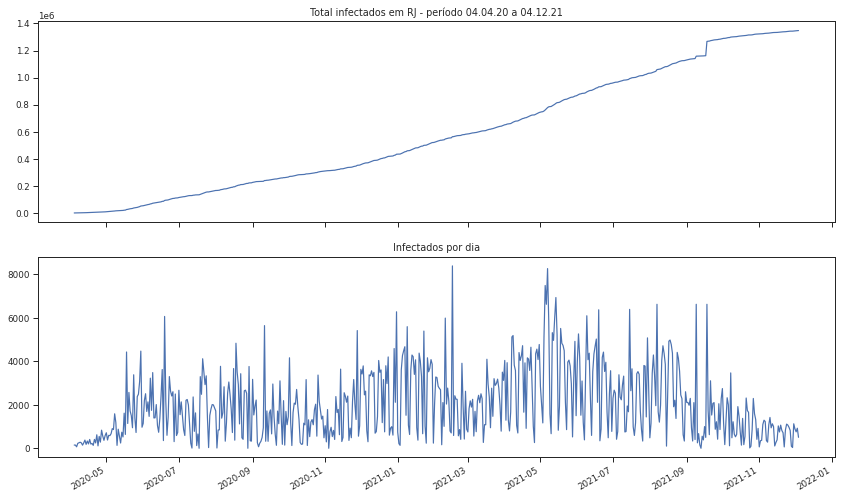

In [19]:
fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(2, 1, 1)
# df.total_infected.plot()
#plt.plot(df.index, df.total_infected.values)
plt.plot(dfRJ.index, dfRJ.total_infectados.values)
plt.title("Total infectados em RJ - período 04.04.20 a 04.12.21")
plt.subplot(2, 1, 2, sharex=ax1)

#plt.plot(df.index, df.infected_per_day.values)
plt.plot(dfRJ.index, dfRJ.infectados_por_dia.values)
plt.title("Infectados por dia")
plt.tight_layout()

fig.autofmt_xdate()
#plt.savefig('figures/habr/infected_overview.png')
plt.show()

OBS: No dia 18.09.2021 ocorreu um outlier devido a dados represados que foram incluídos nesse dia no valor de 105.200 conforme relatado no site g1:
https://g1.globo.com/rj/rio-de-janeiro/noticia/2021/09/18/rj-acrescenta-dados-retroativos-de-covid-19-e-ultrapassa-12-milhao-de-casos-da-doenca.ghtml

In [20]:
#suavização de dados média 7 dias

dfRJ_smoothed = dfRJ.rolling(7).sum()  #esse deu melhor smape

#dfRJ_smoothed = dfRJ.rolling(7).mean().round(5)

#dfRJ_smoothed = dfRJ.rolling(7, center=True, on = 'date').mean().round(2)

dfRJ_smoothed.fillna(value = 0, inplace = True) 


#dfRJ_smoothed['infectados_por_dia_ma7'] = dfRJ['infectados_por_dia'].rolling(7).sum()
##df_nat['mov_avg'] = df_nat['new_cases'].rolling(7).sum()



In [21]:
dfRJ.head()

,date,total_infectados,total_recuperados,total_mortos,mortos_por_dia,infectados_por_dia,recuperados_por_dia,vacinados_por_dia,total_pessoas_vacinadas,total_pessoas_completamente_vacinadas
2020-04-04,2020-04-04,1246,1,58,6,148,0,0,0,0
2020-04-05,2020-04-05,1394,1,64,6,148,0,0,0,0
2020-04-06,2020-04-06,1461,1,71,7,67,0,0,0,0
2020-04-07,2020-04-07,1688,1,89,18,227,0,0,0,0
2020-04-08,2020-04-08,1938,183,106,17,250,182,0,0,0


In [25]:
dfRJ_smoothed.tail()

,total_infectados,total_recuperados,total_mortos,mortos_por_dia,infectados_por_dia,recuperados_por_dia,vacinados_por_dia,total_pessoas_vacinadas,total_pessoas_completamente_vacinadas
2021-11-30,9394721.0,8762362.0,482975.0,177.0,5219.0,0.0,75457.0,93221721.0,73560304.0
2021-12-01,9399718.0,8784782.0,483138.0,163.0,4997.0,6939.0,74883.0,93296604.0,73895647.0
2021-12-02,9404404.0,8807202.0,483305.0,167.0,4686.0,6939.0,68146.0,93364750.0,74190217.0
2021-12-03,9409048.0,8829622.0,483431.0,126.0,4644.0,6939.0,54723.0,93419473.0,74399892.0
2021-12-04,9413375.0,8852042.0,483552.0,121.0,4327.0,6939.0,54811.0,93474284.0,74710620.0


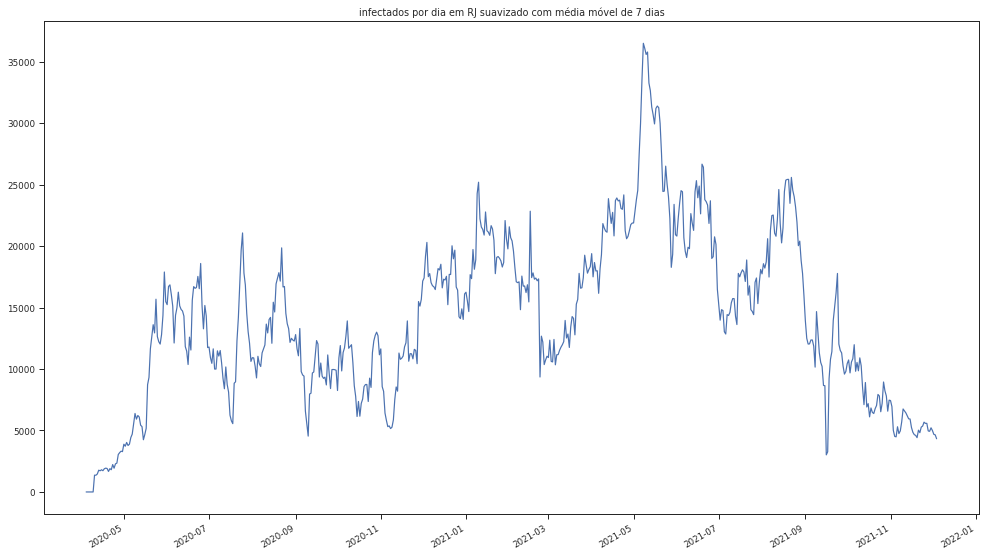

In [22]:
fig = plt.figure(figsize=(14,9))
#ax1 = plt.subplot(2, 1, 1)
plt.plot(dfRJ_smoothed.index, dfRJ_smoothed.infectados_por_dia.values)
plt.title("infectados por dia em RJ suavizado com média móvel de 7 dias")
plt.tight_layout()

fig.autofmt_xdate()
plt.show()

OBS: Início da vacinação no RJ -> 18.01.2021 (começou em Idosos/grupos prioritários)

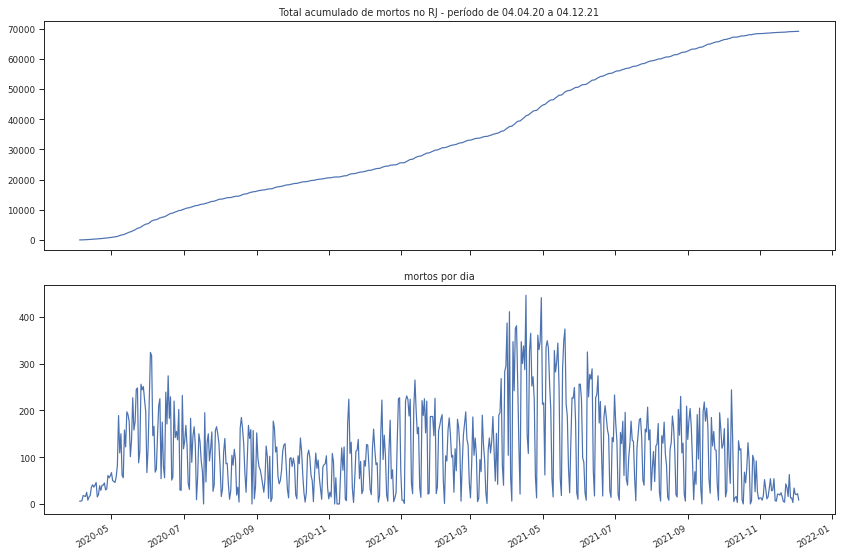

In [27]:
fig = plt.figure(figsize=(12,9))
ax1 = plt.subplot(2, 1, 1)
plt.plot(dfRJ.index, dfRJ.total_mortos.values)
plt.title("Total acumulado de mortos no RJ - período de 04.04.20 a 04.12.21")
plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(dfRJ.index, dfRJ.mortos_por_dia.values)
plt.title("mortos por dia")
plt.tight_layout()

fig.autofmt_xdate()
plt.show()

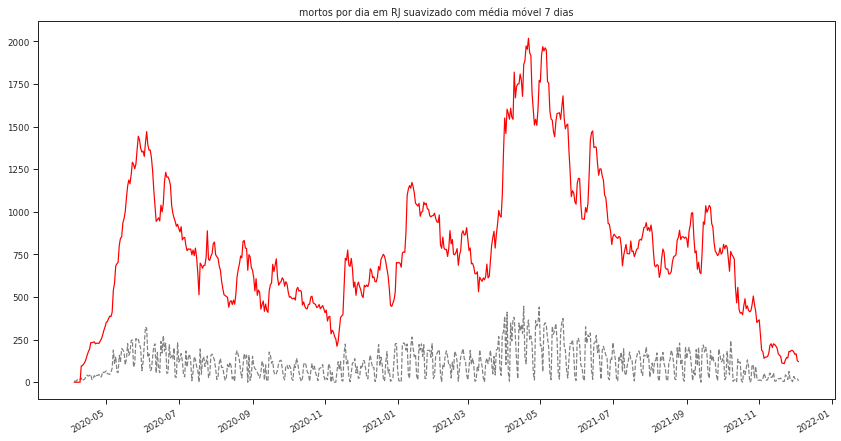

In [26]:
fig = plt.figure(figsize=(12,7))
#ax1 = plt.subplot(2, 1, 1)
plt.plot(dfRJ.index, dfRJ.mortos_por_dia.values, color='gray', linestyle='dashed')
plt.plot(dfRJ_smoothed.index, dfRJ_smoothed.mortos_por_dia.values, color = 'red')
plt.title("mortos por dia em RJ suavizado com média móvel 7 dias")
plt.tight_layout()

fig.autofmt_xdate()
plt.show()

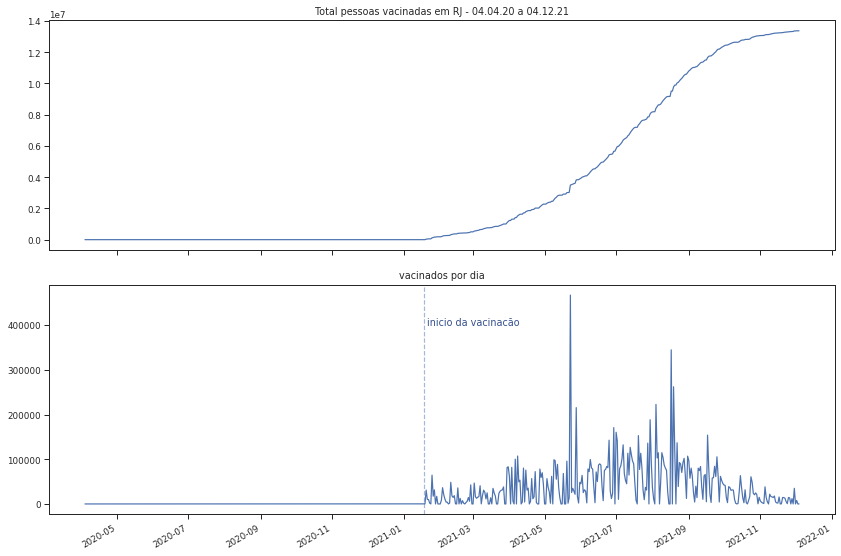

In [27]:
fig = plt.figure(figsize=(12,9))
ax1 = plt.subplot(2, 1, 1)
plt.plot(dfRJ.index, dfRJ.total_pessoas_vacinadas.values)
plt.title("Total pessoas vacinadas em RJ - 04.04.20 a 04.12.21")
plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(dfRJ.index, dfRJ.vacinados_por_dia.values)
plt.title("vacinados por dia")

x_line_annotation = pd.to_datetime('2021-01-18')
x_text_annotation = x_line_annotation + pd.to_timedelta(3, unit='D')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
plt.text(x=x_text_annotation, 
         y=400000, 
        s='inicio da vacinacão', 
         horizontalalignment='left',
        color='#334f8d',
        fontweight='medium')

plt.tight_layout()
fig.autofmt_xdate()
plt.show()

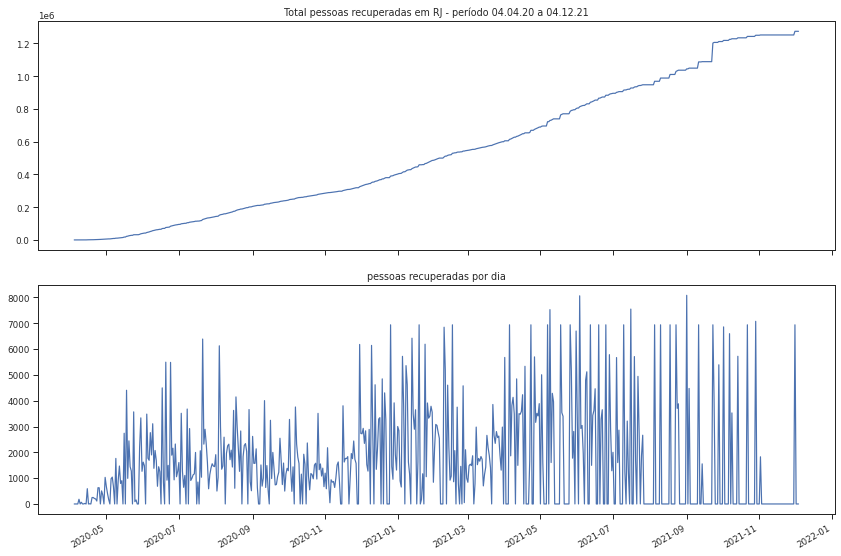

In [28]:
fig = plt.figure(figsize=(12,9))
ax1 = plt.subplot(2, 1, 1)
plt.plot(dfRJ.index, dfRJ.total_recuperados.values)
plt.title("Total pessoas recuperadas em RJ - período 04.04.20 a 04.12.21")
plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(dfRJ.index, dfRJ.recuperados_por_dia.values)
plt.title("pessoas recuperadas por dia")
plt.tight_layout()

fig.autofmt_xdate()
plt.show()

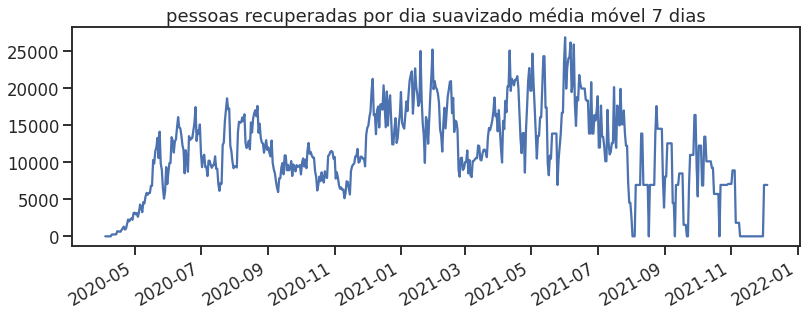

In [27]:
fig = plt.figure(figsize=(12,9))
ax1 = plt.subplot(2, 1, 1)
plt.plot(dfRJ_smoothed.index, dfRJ_smoothed.recuperados_por_dia.values)
plt.title("pessoas recuperadas por dia suavizado média móvel 7 dias")
plt.tight_layout()

fig.autofmt_xdate()
plt.show()

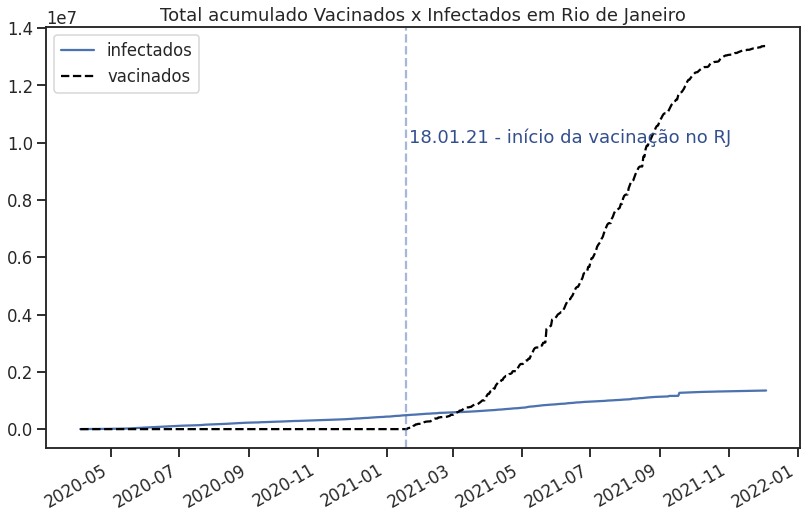

In [33]:
fig = plt.figure(figsize=(12, 8))
plt.plot(dfRJ.index, dfRJ.total_infectados.values,label='infectados')
plt.plot(dfRJ.index, dfRJ.total_pessoas_vacinadas.values, label='vacinados', color='black', linestyle='dashed')
#plt.plot(train_subset.date, train_subset['total_mortos'], label='dado histórico')
#plt.plot(train_subset.date, D, label='previsto', color='black', linestyle='dashed' )
plt.legend()
plt.title('Total acumulado Vacinados x Infectados em Rio de Janeiro')
x_line_annotation = pd.to_datetime('2021-01-18')
x_text_annotation = x_line_annotation + pd.to_timedelta(3, unit='D')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
plt.text(x=x_text_annotation, 
         y=10000000, 
        s='18.01.21 - início da vacinação no RJ', 
         horizontalalignment='left',
        color='#334f8d',
        fontweight='medium')

plt.tight_layout()
fig.autofmt_xdate()
plt.show()

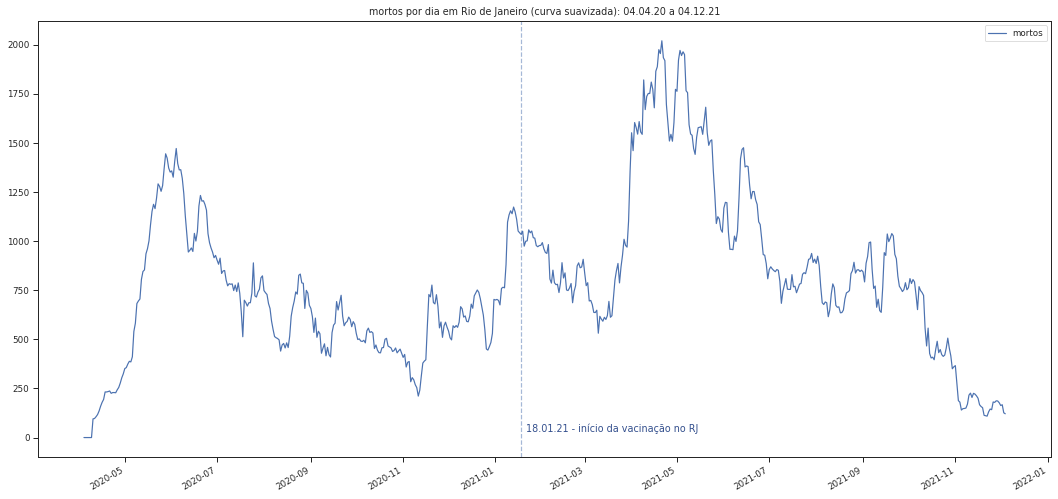

In [30]:
fig = plt.figure(figsize=(15, 8))
plt.plot(dfRJ.index, dfRJ_smoothed.mortos_por_dia.values,label='mortos')
#plt.plot(dfRJ.index, dfRJ.total_pessoas_vacinadas.values, label='vacinados', color='black', linestyle='dashed')
#plt.plot(train_subset.date, train_subset['total_mortos'], label='dado histórico')
#plt.plot(train_subset.date, D, label='previsto', color='black', linestyle='dashed' )
plt.legend()
plt.title('mortos por dia em Rio de Janeiro (curva suavizada): 04.04.20 a 04.12.21')

x_line_annotation = pd.to_datetime('2021-01-18')
x_text_annotation = x_line_annotation + pd.to_timedelta(3, unit='D')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
plt.text(x=x_text_annotation, 
         y=30, 
        s='18.01.21 - início da vacinação no RJ', 
         horizontalalignment='left',
        color='#334f8d',
        fontweight='medium')


plt.tight_layout()
fig.autofmt_xdate()
plt.show()

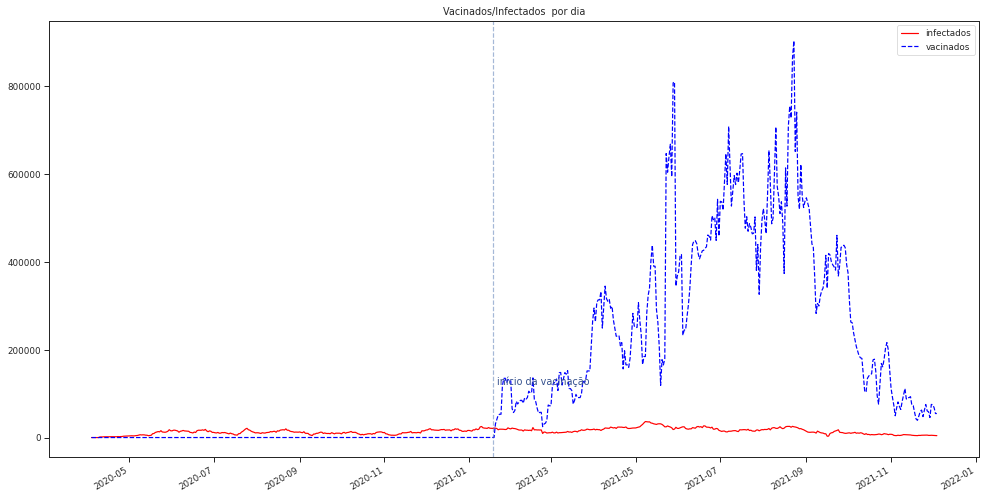

In [31]:
#suavizado

fig = plt.figure(figsize=(14, 8))
plt.plot(dfRJ.index, dfRJ_smoothed.infectados_por_dia.values,label='infectados', color = 'red')
plt.plot(dfRJ.index, dfRJ_smoothed.vacinados_por_dia.values, label='vacinados', color='blue', linestyle='dashed')
#plt.plot(train_subset.date, train_subset['total_mortos'], label='dado histórico')
#plt.plot(train_subset.date, D, label='previsto', color='black', linestyle='dashed' )
plt.legend()
plt.title('Vacinados/Infectados  por dia')

x_line_annotation = pd.to_datetime('2021-01-18')
x_text_annotation = x_line_annotation + pd.to_timedelta(3, unit='D')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
plt.text(x=x_text_annotation, 
         y=120000, 
        s='início da vacinação', 
         horizontalalignment='left',
        color='#334f8d',
        fontweight='medium')

plt.tight_layout()
fig.autofmt_xdate()
plt.show()

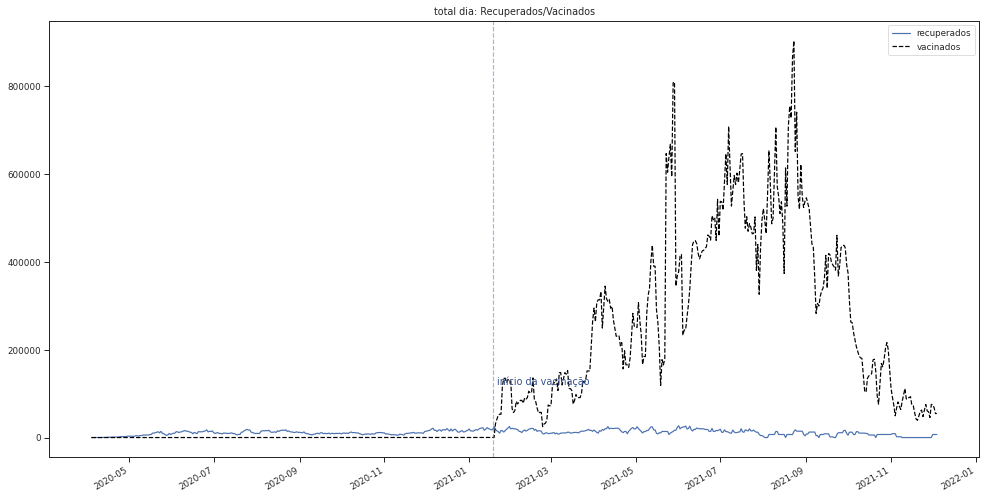

In [32]:
#suavizado

fig = plt.figure(figsize=(14, 8))
plt.plot(dfRJ.index, dfRJ_smoothed.recuperados_por_dia.values,label='recuperados')
plt.plot(dfRJ.index, dfRJ_smoothed.vacinados_por_dia.values, label='vacinados', color='black', linestyle='dashed')
#plt.plot(train_subset.date, train_subset['total_mortos'], label='dado histórico')
#plt.plot(train_subset.date, D, label='previsto', color='black', linestyle='dashed' )
plt.legend()
plt.title('total dia: Recuperados/Vacinados')

x_line_annotation = pd.to_datetime('2021-01-18')
x_text_annotation = x_line_annotation + pd.to_timedelta(3, unit='D')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
plt.text(x=x_text_annotation, 
         y=120000, 
        s='início da vacinação', 
         horizontalalignment='left',
        color='#334f8d',
        fontweight='medium')

plt.tight_layout()
fig.autofmt_xdate()
plt.show()

SUAVIZAÇÃO DE DADOS - MÉDIA MÓVEL 7 DIAS

In [23]:
#dfRJ_smoothed = dfRJ.rolling(7).mean().round(5) //já feito acima

dfRJ_smoothed.columns = [col + '_ma7' for col in dfRJ_smoothed.columns]

full_dfRJ = pd.concat([dfRJ, dfRJ_smoothed], axis=1)

#for column in full_dfRJ.columns:
#    if column.endswith('_ma7'):
#        original_column = column.strip('_ma7')
#        full_dfRJ[column] = full_dfRJ[column].fillna(full_dfRJ[original_column])


In [30]:
dfRJ.tail()

,date,total_infectados,total_recuperados,total_mortos,mortos_por_dia,infectados_por_dia,recuperados_por_dia,vacinados_por_dia,total_pessoas_vacinadas,total_pessoas_completamente_vacinadas
2021-11-30,2021-11-30,1343927,1251766,69061,34,1126,0,34959,13360055,10662768
2021-12-01,2021-12-01,1344816,1274186,69082,21,889,6939,95,13360150,10670528
2021-12-02,2021-12-02,1345572,1274186,69102,20,756,0,7783,13367933,10713965
2021-12-03,2021-12-03,1346494,1274186,69124,22,922,0,0,13367933,10713965
2021-12-04,2021-12-04,1346998,1274186,69132,8,504,0,88,13368021,10815018


In [28]:
dfRJ_smoothed.head(10)

,total_infectados_ma7,total_recuperados_ma7,total_mortos_ma7,mortos_por_dia_ma7,infectados_por_dia_ma7,recuperados_por_dia_ma7,vacinados_por_dia_ma7,total_pessoas_vacinadas_ma7,total_pessoas_completamente_vacinadas_ma7
2020-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-10,12407.0,618.0,657.0,95.0,1366.0,247.0,0.0,0.0,0.0
2020-04-11,13768.0,865.0,754.0,97.0,1361.0,247.0,0.0,0.0,0.0
2020-04-12,15229.0,1115.0,860.0,106.0,1461.0,250.0,0.0,0.0,0.0
2020-04-13,16999.0,1385.0,977.0,117.0,1770.0,270.0,0.0,0.0,0.0


In [29]:
full_dfRJ.head()

,date,total_infectados,total_recuperados,total_mortos,mortos_por_dia,infectados_por_dia,recuperados_por_dia,vacinados_por_dia,total_pessoas_vacinadas,total_pessoas_completamente_vacinadas,total_infectados_ma7,total_recuperados_ma7,total_mortos_ma7,mortos_por_dia_ma7,infectados_por_dia_ma7,recuperados_por_dia_ma7,vacinados_por_dia_ma7,total_pessoas_vacinadas_ma7,total_pessoas_completamente_vacinadas_ma7
2020-04-04,2020-04-04,1246,1,58,6,148,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-05,2020-04-05,1394,1,64,6,148,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-06,2020-04-06,1461,1,71,7,67,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-07,2020-04-07,1688,1,89,18,227,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-08,2020-04-08,1938,183,106,17,250,182,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
dfRJ = full_dfRJ

In [ ]:
#def minmax_norm(df_input):
#    return (df - df.min()) / ( df.max() - df.min())



In [ ]:
#dfRJ_norm = minmax_norm(dfRJ)

In [ ]:
#dfRJ_norm.head(10)

In [ ]:
#preencher NaN com zeros
#dfRJ.fillna(value = 0, inplace = True) 

In [38]:
#from IPython.display import display, HTML

#display(dfRJ)
# display(HTML(df.to_html()))

In [25]:
dfRJ_smoothed.head(15)

,total_infectados_ma7,total_recuperados_ma7,total_mortos_ma7,mortos_por_dia_ma7,infectados_por_dia_ma7,recuperados_por_dia_ma7,vacinados_por_dia_ma7,total_pessoas_vacinadas_ma7,total_pessoas_completamente_vacinadas_ma7
2020-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-10,12407.0,618.0,657.0,95.0,1366.0,247.0,0.0,0.0,0.0
2020-04-11,13768.0,865.0,754.0,97.0,1361.0,247.0,0.0,0.0,0.0
2020-04-12,15229.0,1115.0,860.0,106.0,1461.0,250.0,0.0,0.0,0.0
2020-04-13,16999.0,1385.0,977.0,117.0,1770.0,270.0,0.0,0.0,0.0


In [26]:
#periodo da simulação: 04.04.20 a 04.12.21
DATA_CORTE = '2021-06-04' 

#para inicialização dos parâmetros-para ajuste exponencial da curva 
#periodo da simulação: 04.04.20 a 04.10.20
#DATA_CORTE = '2020-06-04' 


#70% treino
#30% teste

In [27]:
train_subset = dfRJ[
    #(df.date >= '2020-03-25') &
    (dfRJ.date <= DATA_CORTE)]


In [28]:
test_subset = dfRJ[dfRJ.date > train_subset.iloc[-1].date]
test_subset.date[:3]

2021-06-05   2021-06-05
2021-06-06   2021-06-06
2021-06-07   2021-06-07
Freq: D, Name: date, dtype: datetime64[ns]

In [29]:
train_subset.tail()

,date,total_infectados,total_recuperados,total_mortos,mortos_por_dia,infectados_por_dia,recuperados_por_dia,vacinados_por_dia,total_pessoas_vacinadas,total_pessoas_completamente_vacinadas,total_infectados_ma7,total_recuperados_ma7,total_mortos_ma7,mortos_por_dia_ma7,infectados_por_dia_ma7,recuperados_por_dia_ma7,vacinados_por_dia_ma7,total_pessoas_vacinadas_ma7,total_pessoas_completamente_vacinadas_ma7
2021-05-31,2021-05-31,865363,801877,50584,10,1498,6698,48278,3889010,1726133,5999962.0,5531018.0,351778.0,1045.0,20921.0,23378.0,367906.0,26137866.0,11619431.0
2021-06-01,2021-06-01,869302,805372,50840,256,3939,3495,45094,3934104,1742014,6020769.0,5566011.0,352946.0,1168.0,20807.0,26873.0,378028.0,26515894.0,11778549.0
2021-06-02,2021-06-02,874560,805372,51096,256,5258,0,64009,3998113,1760158,6043049.0,5585945.0,354143.0,1197.0,22280.0,19934.0,413242.0,26929136.0,11947412.0
2021-06-03,2021-06-03,878747,813434,51320,224,4187,8062,25381,4023494,1766692,6066552.0,5608783.0,355338.0,1195.0,23503.0,22838.0,416987.0,27346123.0,12115380.0
2021-06-04,2021-06-04,880267,816359,51419,99,1520,2925,31667,4055161,1773431,6091053.0,5632772.0,356383.0,1045.0,24501.0,23989.0,233179.0,27579302.0,12184640.0


# Modelo SEIRD Clássico

In [30]:
import lmfit # O método de otimização Levenberg-Marquardt

In [31]:
class DefineParamsSEIR:
    def __init__(self, params=None):
        self.params = params

    def get_fit_params(self):
        params = lmfit.Parameters()
        params.add("population", value=12_000_000, vary=False)
        params.add("epidemic_started_days_ago", value=30, vary=False)

        #parametros iniciais RJ encontrados na simulacao de 6meses:
        params.add("r0", value=2.5, min=2, max=3, vary=True) #param estimado p/ RJ
        params.add("alpha", value=0.0078, min=0.005, max=0.0078, vary=True) #taxa de letalidade param estimado p/ RJ em 2021
        #params.add("alpha", value=0.0064, min=0.005, max=0.0078, vary=True)  # CFR
        params.add("delta", value=1/2, min=1/14, max=1/2, vary=True)  # E -> I rate
        params.add("gamma", value=1/14, min=1/14, max=1/7, vary=True) #param estimado p/ RJ
        #params.add("gamma", value=1/9, min=1/14, max=1/7, vary=True)  # I -> R rate
        params.add("rho", expr='gamma', vary=False)  # I -> D rate
#vacinacao--------------------
        params.add("mi", value=0.4, min=0.2, max=1, vary=True)
        params.add("lambda1", value=0.6, min=0.3, max=1, vary=True)
        
#-----------------------------  


        return params

    def get_initial_conditions(self, data):
        # Simulate such initial params as to obtain as many deaths as in data
        # (Simule tais parâmetros iniciais para obter tantas mortes quanto nos dados)
        population = self.params['population']
        epidemic_started_days_ago = self.params['epidemic_started_days_ago']

        t = np.arange(epidemic_started_days_ago)
        (S, E, I, R, D, V) = self.predict(t, (population - 1, 0, 1, 0, 0, 0))

        I0 = I[-1]
        E0 = E[-1]
        Rec0 = R[-1]
        D0 = D[-1]
        S0 = S[-1]
        V0 = V[-1]
        return (S0, E0, I0, Rec0, D0, V0)

    def step(self, initial_conditions, t):
        population = self.params['population']
        delta = self.params['delta']
        gamma = self.params['gamma']
        alpha = self.params['alpha']
        rho = self.params['rho']
#vacinacao---------------------
        mi = self.params['mi']
        lambda1 = self.params['lambda1'] 
#------------------------------              
        
        rt = self.params['r0'].value
        beta = rt * gamma

        S, E, I, R, D, V = initial_conditions

#-----------------------------------------------
        #new_succetives = -beta * I * (S / population) - mi * (S / population)
        #new_exposed = beta * I * (S / population) + beta * I * (V / population) - delta * E
        #new_infected = delta * E - gamma * (1 - alpha) * I
        #new_recovered = gamma * I + lambda1 * V
        #new_dead = gamma * alpha * I   
        
#vacinacao--------------------------------------    
        #new_vaccinated = mi * (S / population) - beta * I * (V / population) - lambda1 * V
#----------------------------------------------- 

        new_succetives = -beta * I * (S / population) 
        new_exposed = beta * I * (S / population) - delta * E
        #new_infected = delta * E
        new_infected = delta * E - gamma * alpha * I - gamma * (1 - alpha) * I
        new_recovered = gamma * (1 - alpha) * I
        new_dead = gamma * alpha * I

        #new_vaccinated = (1 - beta) * I * (S / population)
        new_vaccinated = (1 - beta) * (S / population)

        new_imunes = beta * I * (V / population)
#-----------------------------------------------
        dSdt = new_succetives - new_vaccinated
        dEdt = new_exposed
        dIdt = new_infected
        dRdt = new_recovered
        dDdt = new_dead
    #vacinacao--------------------------------------
        dVdt = new_vaccinated
    #-----------------------------------------------

  

        assert S + E + I + R + D + V - population <= 1e10
        assert dSdt + dIdt + dEdt + dRdt + dDdt + dVdt <= 1e10
        return dSdt, dEdt, dIdt, dRdt, dDdt, dVdt

    def predict(self, t_range, initial_conditions):
        ret = odeint(self.step, initial_conditions, t_range)
        return ret.T

In [32]:
model = DefineParamsSEIR()
model.params = model.get_fit_params()
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, R, D, V) = model.predict(train_t, train_initial_conditions)

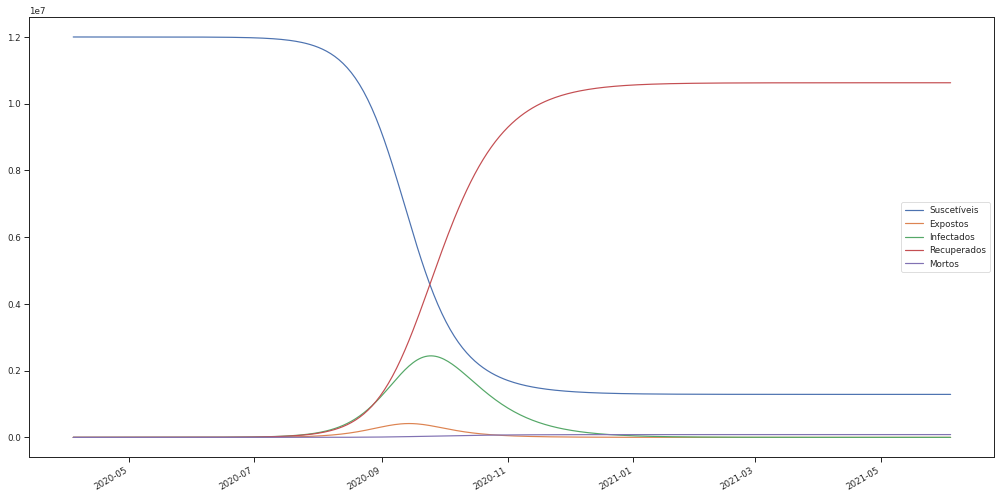

In [33]:
fig = plt.figure(figsize=(14,8))
plt.plot(train_subset.date, S, label='Suscetíveis')
plt.plot(train_subset.date, E, label='Expostos')
plt.plot(train_subset.date, I, label='Infectados')
plt.plot(train_subset.date, R, label='Recuperados')
plt.plot(train_subset.date, D, label='Mortos')
plt.legend()
plt.tight_layout()
fig.autofmt_xdate()
plt.show()

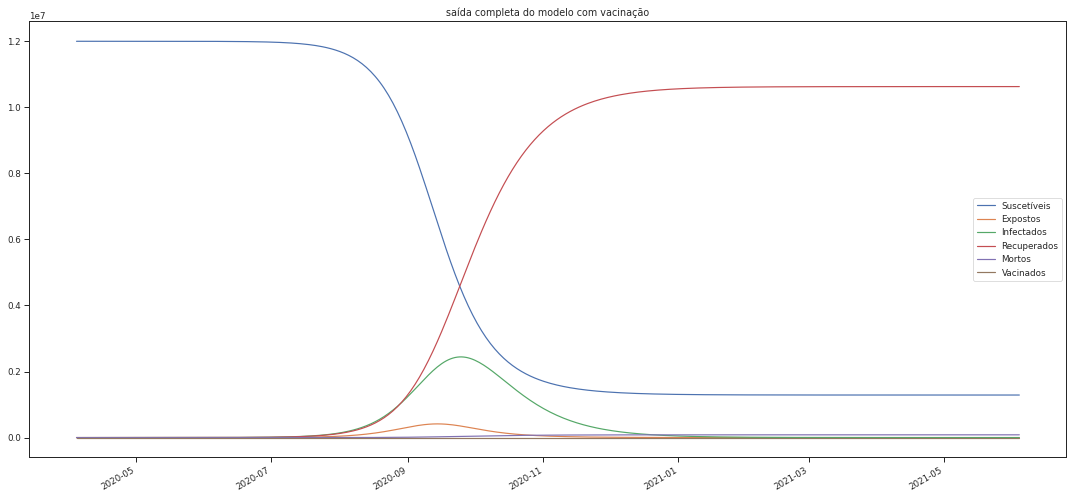

In [42]:
#train_subset com dfRJ
#DATA_CORTE = '2021-12-16'
#importante : nessa simulação o R0 = 2.5 no método get_fit_params da classe DefineParamsSEIR

#saída completa do modelo com Vacinação e possibilidade de recuperados se tornarem suscetíveis com alguma probabilidade

fig = plt.figure(figsize=(15,8))
plt.plot(train_subset.date, S, label='Suscetíveis')
plt.plot(train_subset.date, E, label='Expostos')
plt.plot(train_subset.date, I, label='Infectados')
plt.plot(train_subset.date, R, label='Recuperados')
plt.plot(train_subset.date, D, label='Mortos')
#incluindo vacinados----------------------
plt.plot(train_subset.date, V, label='Vacinados')
#----------------------------------------
plt.legend()
plt.title('saída completa do modelo com vacinação')
plt.tight_layout()
fig.autofmt_xdate()
plt.show()

In [ ]:
#fig = plt.figure(figsize=(10, 7))
#plt.plot(train_subset.date, train_subset['total_dead'], label='dado histórico')
#plt.plot(train_subset.date, D, label='previsto', color='black', linestyle='dashed' )
#plt.legend()
#plt.title('Total mortes')
#plt.tight_layout()
#fig.autofmt_xdate()
#plt.show()

In [34]:
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('seaborn-poster')
matplotlib.rcParams['figure.figsize'] = (10., 6.)

In [40]:
#dd = np.arange(len(dfRJ.index))
#tt = np.arange(len(train_subset))
#tt = np.arange(len(dfRJ_smoothed.index))
tt = np.arange(len(dfRJ.index))

In [41]:
print(tt)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [42]:
def exponential_fit(cases,start,length):

    def resid(beta):
        prediction = cases[start]*np.exp(beta*(tt-start))
        return prediction[start:start+length]-cases[start:start+length]

    soln = optimize.least_squares(resid,0.2)
    beta = soln.x[0]
    return beta


#plot curva ajustada
def plot_fit(cases,start,end):
    length=end-start
    plt.plot(tt,cases)
    beta = exponential_fit(cases,start,length)
    prediction = cases[start]*np.exp(beta*(tt-start))
    plt.plot(tt[start:start+length],prediction[start:start+length],'--k');
    #plt.legend(['Dados reais',r'fit com $\beta$={:.3f}'.format(beta)]);
    plt.legend(['Dados reais',r'fit']);
    plt.xlabel('Dias'); plt.ylabel('Total de mortos');
    return beta 

In [43]:
#total_cases = [dfRJ.total_mortos.values for day in dfRJ.index]

total_cases = dfRJ.total_mortos.values
#total_cases = train_subset.total_mortos.values
#total_cases = dfRJ_smoothed.total_mortos_ma7.values


In [ ]:
#plt.plot(dd, total_cases);

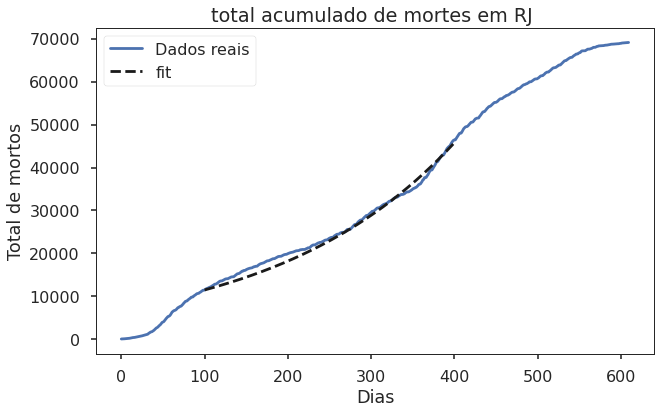

In [44]:
beta = plot_fit(total_cases,start=100,end=400)
plt.title('total acumulado de mortes em RJ ');

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [46]:
start = 0


In [47]:
def calcMAE(cases,start,end):
    length=end-start
    #dd = np.arange(len(days))
    beta = exponential_fit(cases,start,length)
    prediction = cases[start]*np.exp(beta*(tt-start))
#    plt.plot(dd[start:start+length],prediction[start:start+length],'--k');
#    plt.legend(['Dados reais',r'fit com $\beta$={:.3f}'.format(beta)]);
#    plt.xlabel('Dias'); plt.ylabel('Total de casos');
#    MSE = mean_squared_error(dd[start:start+length], prediction[start:start+length])
    MAE = mean_absolute_error(total_cases[start:start+length], prediction[start:start+length])
    return MAE

In [48]:
MAE = calcMAE(total_cases, start=80, end=170)
print(MAE)

579.9015492546727


In [49]:
beta = exponential_fit(total_cases,start,90)
prediction = total_cases[start]*np.exp(beta*(tt-start))

In [50]:
def calcSMAPE(A, F):
    #return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    #return  np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    
    return np.abs((F - A) / (np.abs(F) + np.abs(A))/2).mean()
    

#A = np.array([2,3,4,5,6,7,8,9])
#F = np.array([1,3,5,4,6,7,10,7])
#print(smape(A, F))

In [51]:
SMAPE = calcSMAPE(total_cases[start:170], prediction[start:170])
print(SMAPE)

0.27354733842003726


In [52]:
SMAPE= calcSMAPE(total_cases[start:], prediction[start:])
print(SMAPE)

0.43667365047865286


In [36]:
from utils import smape

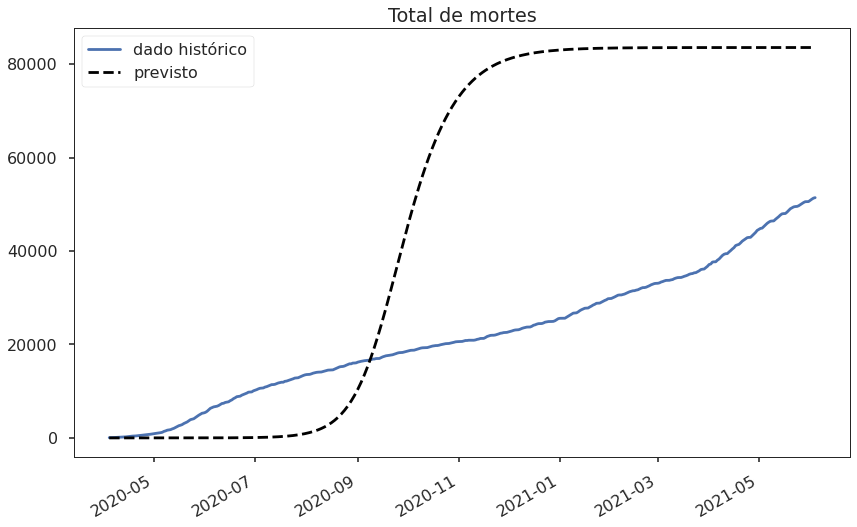

In [54]:
#aqui é train_subset do dfRJ

#importante : #importante : nessa simulação o R0 = 3 no método get_fit_params da classe DefineParamsSEIR

fig = plt.figure(figsize=(12, 8))
plt.plot(train_subset.date, train_subset['total_mortos'], label='dado histórico')
plt.plot(train_subset.date, D, label='previsto', color='black', linestyle='dashed' )
plt.legend()
plt.title('Total de mortes')
plt.tight_layout()
fig.autofmt_xdate()
plt.show()

#medidas de Quarentena

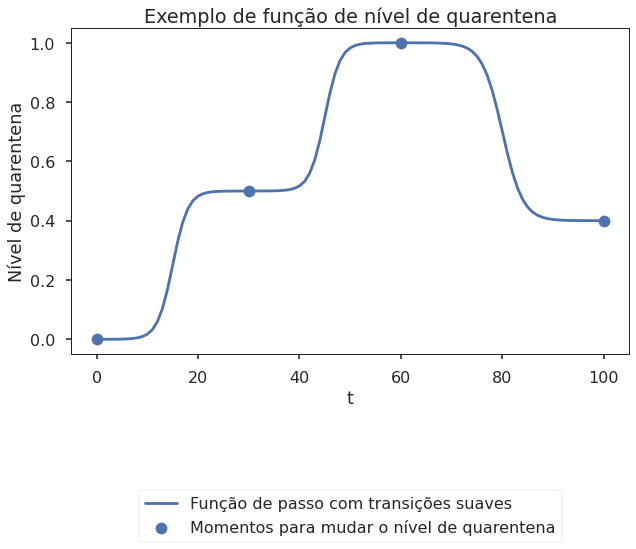

In [37]:
def sigmoid(x, xmin, xmax, a, b, c, r):
    x_scaled = (x - xmin) / (xmax - xmin) #normalização dos dados
    out = (a * np.exp(c * r) + b * np.exp(r * x_scaled)) / (np.exp(c * r) + np.exp(x_scaled * r))
    return out


def stepwise_soft(t, coefficients, r=20, c=0.5):
    t_arr = np.array(list(coefficients.keys()))

    min_index = np.min(t_arr)
    max_index = np.max(t_arr)

    if t <= min_index:
        return coefficients[min_index]
    elif t >= max_index:
        return coefficients[max_index]
    else:
        index = np.min(t_arr[t_arr >= t])

    if len(t_arr[t_arr < index]) == 0:
        return coefficients[index]
    prev_index = np.max(t_arr[t_arr < index])
    # sigmoid smoothing
    q0, q1 = coefficients[prev_index], coefficients[index]
    out = sigmoid(t, prev_index, index, q0, q1, c, r)
    return out

t_range = np.arange(100)
coefficients = {
    0: 0,
    30: 0.5,
    60: 1,
    100: 0.4,
}

plt.title('Exemplo de função de nível de quarentena')
plt.scatter(coefficients.keys(), coefficients.values(), label='Momentos para mudar o nível de quarentena')
plt.plot(t_range, [stepwise_soft(t, coefficients, r=20, c=0.5) for t in t_range], label='Função de passo com transições suaves')
plt.xlabel('t')
plt.ylabel('Nível de quarentena')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6),)
plt.show()

# Treinar SEIRD + incerteza de dados(grupos auxiliares) + quarentena

In [38]:
#from fitters2 import CurveFitter_ID
from fitters3 import CurveFitter_ID
#from models2 import SEIR_ID
from models_v3_txVac import SEIR_ID



In [39]:
stepwize_size = 60
#calibrando pesos devido a vacinação, maior peso para recuperados, e menor peso para mortos
weights = {
    'I': 0.3,
    'R': 0.5, 
    'D': 0.3,
}
model = SEIR_ID(stepwise_size=stepwize_size)
fitter = CurveFitter_ID(
     new_deaths_col='mortos_por_dia_ma7',
     new_cases_col='infectados_por_dia_ma7',
     new_recoveries_col='recuperados_por_dia_ma7',
     
     weights=weights,
     max_iters=1000,
     save_params_every=50,
)
fitter.fit(model, train_subset)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:
result = fitter.result
result

In [41]:
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, Iv, R, Rv, D, Dv, V), history = model.predict(train_t, train_initial_conditions)
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible, new_vaccinated) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv, V)

In [42]:
daily_df = pd.DataFrame(
    {
        'date': train_subset.date[1:].values,
        'new_exposed': new_exposed,
        'new_infected_invisible': new_infected_invisible,
        'new_infected_visible': new_infected_visible,
        'new_recovered_invisible': new_recovered_invisible,
        'new_recovered_visible': new_recovered_visible,
        'new_dead_invisible': new_dead_invisible,
        'new_dead_visible': new_dead_visible,
        'new_vaccinated': new_vaccinated
    },
    index=train_subset.date[1:])

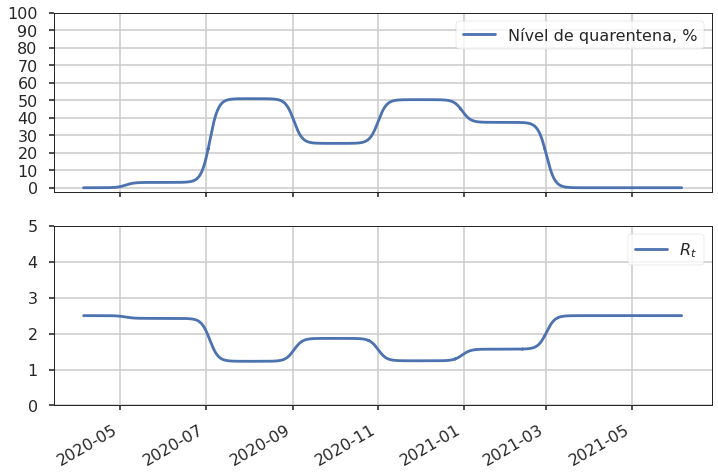

In [43]:
history_dates = dfRJ.date.iloc[0] + pd.to_timedelta(history.t, unit='days')

fig = plt.figure(figsize=(10, 7))
ax1 = plt.subplot(2,1,1)
plt.plot(history_dates, history.quarantine_mult, label='Nível de quarentena, %')
plt.legend()
plt.tight_layout()
y_ticks = list(np.arange(0, 1.1, 0.1).round(1))
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels([f'{int(100*t)}' for t in y_ticks])
plt.grid()

plt.subplot(2,1,2, sharex=ax1)
plt.plot(history_dates, history.rt, label='$R_t$')
plt.ylim(0, 5)
plt.grid()
plt.legend()

fig.autofmt_xdate()
plt.show()

In [44]:
print(history.rt.mean())

1.858261438238836


In [45]:
sns.set_context("paper")
sns.set_style("ticks")

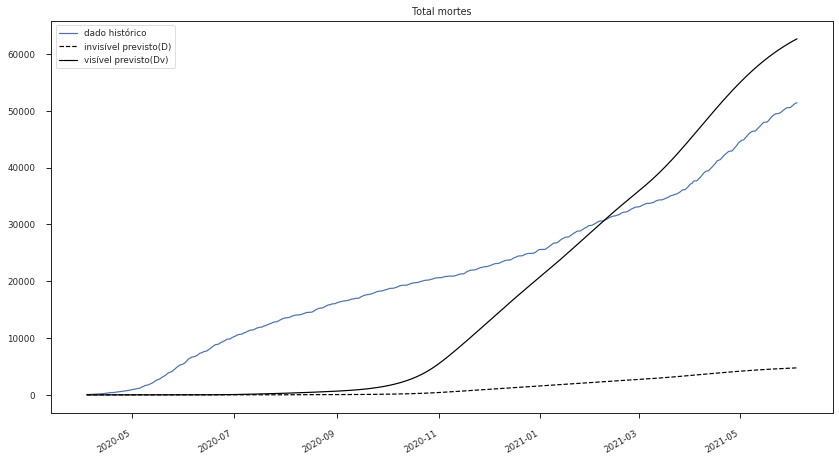

In [46]:
fig = plt.figure(figsize=(14, 8))
plt.plot(train_subset.date, train_subset['total_mortos'], label='dado histórico')
plt.plot(train_subset.date, D, label='invisível previsto(D)', color='black', linestyle='dashed' )
plt.plot(train_subset.date, Dv, label='visível previsto(Dv)', color='black')
#plt.legend()
plt.legend(loc="upper left")
plt.title('Total mortes')
fig.autofmt_xdate()
plt.show()


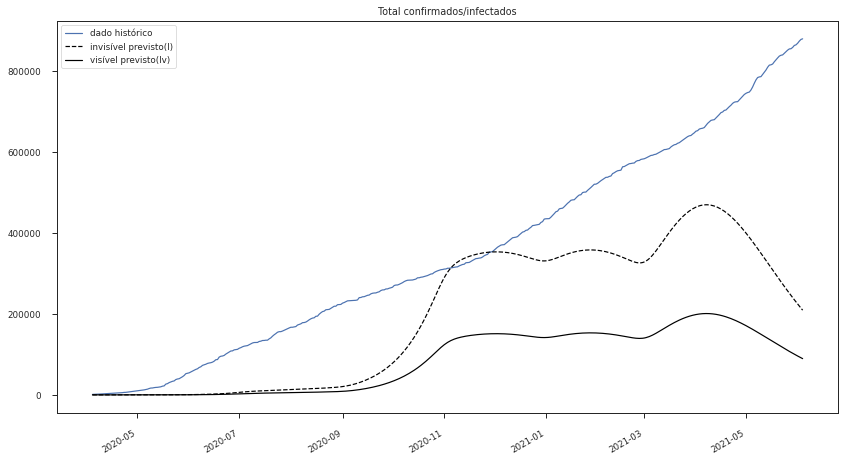

In [47]:
fig = plt.figure(figsize=(14, 8))
plt.plot(train_subset.date, train_subset['total_infectados'], label='dado histórico')
plt.plot(train_subset.date, I, label='invisível previsto(I)', color='black', linestyle='dashed' )
plt.plot(train_subset.date, Iv, label='visível previsto(Iv)', color='black')
#plt.legend()
plt.legend(loc="upper left")
plt.title('Total confirmados/infectados')
fig.autofmt_xdate()
plt.show()

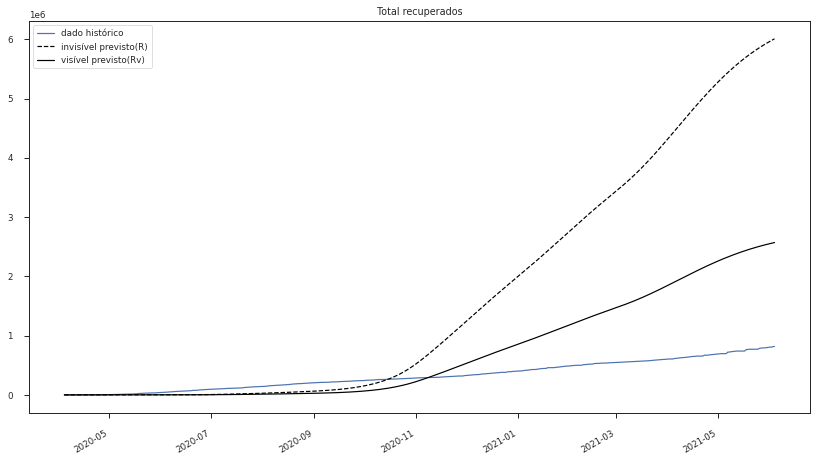

In [48]:
fig = plt.figure(figsize=(14, 8))
plt.plot(train_subset.date, train_subset.total_recuperados, label='dado histórico')
plt.plot(train_subset.date, R, label='invisível previsto(R)', color='black', linestyle='dashed' )
plt.plot(train_subset.date, Rv, label='visível previsto(Rv)', color='black')
plt.legend()
plt.title('Total recuperados')
fig.autofmt_xdate()
plt.show()

In [49]:
train_subset_smoothed = train_subset.rolling(7).mean().round(5)
test_subset_smoothed = test_subset.rolling(7).mean().round(5)

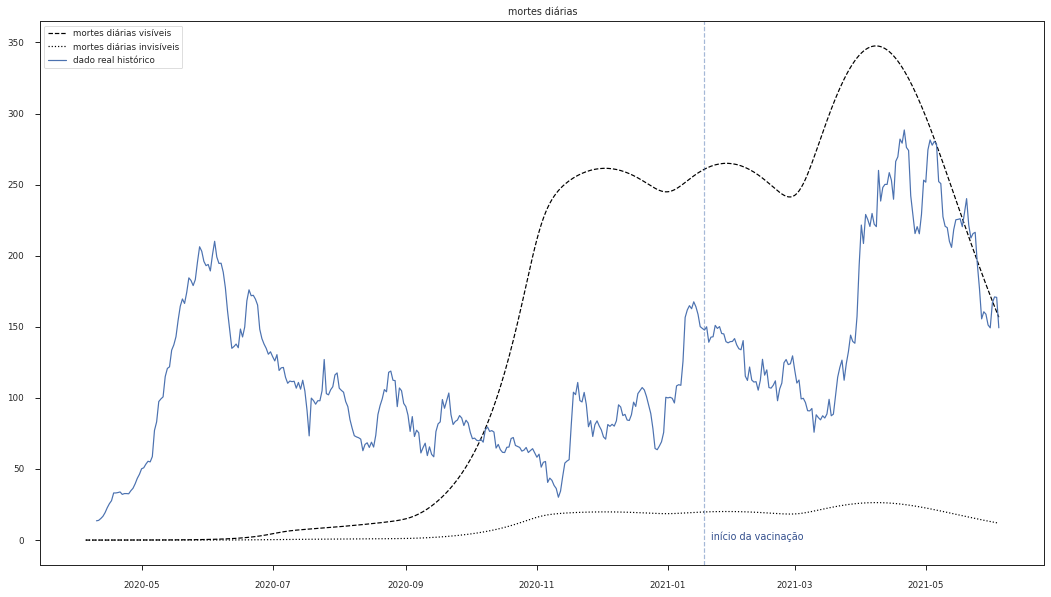

In [50]:
plt.figure(figsize=(18, 10))
plt.plot(daily_df.new_dead_visible, label='mortes diárias visíveis', color='black', linestyle='dashed')
plt.plot(daily_df.new_dead_invisible, label='mortes diárias invisíveis', color='black', linestyle=':')
plt.plot(train_subset.date, train_subset_smoothed['mortos_por_dia'], label='dado real histórico')
#plt.legend()
plt.legend(loc="upper left")
plt.title('mortes diárias')

x_line_annotation = pd.to_datetime('2021-01-18')
x_text_annotation = x_line_annotation + pd.to_timedelta(3, unit='D')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
plt.text(x=x_text_annotation, 
         y=0, 
        s='início da vacinação', 
         horizontalalignment='left',
        color='#334f8d',
        fontweight='medium')

fig.autofmt_xdate()
plt.show()

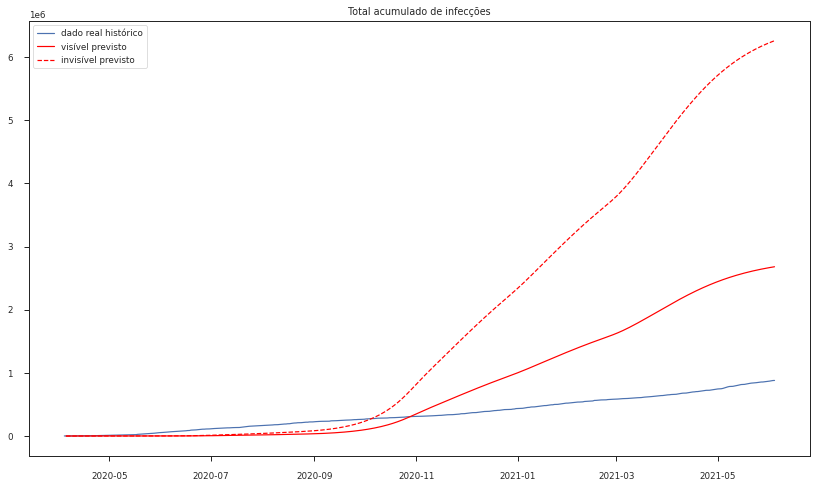

In [51]:
plt.figure(figsize=(14, 8))
plt.plot(train_subset.date, train_subset['total_infectados'], label='dado real histórico')
plt.plot(daily_df.new_infected_visible.cumsum(), label='visível previsto', color='red')
plt.plot(daily_df.new_infected_invisible.cumsum(), label='invisível previsto', color='red',  linestyle='dashed' )
#plt.legend()
plt.legend(loc="upper left")
plt.title('Total acumulado de infecções')
fig.autofmt_xdate()
plt.show()

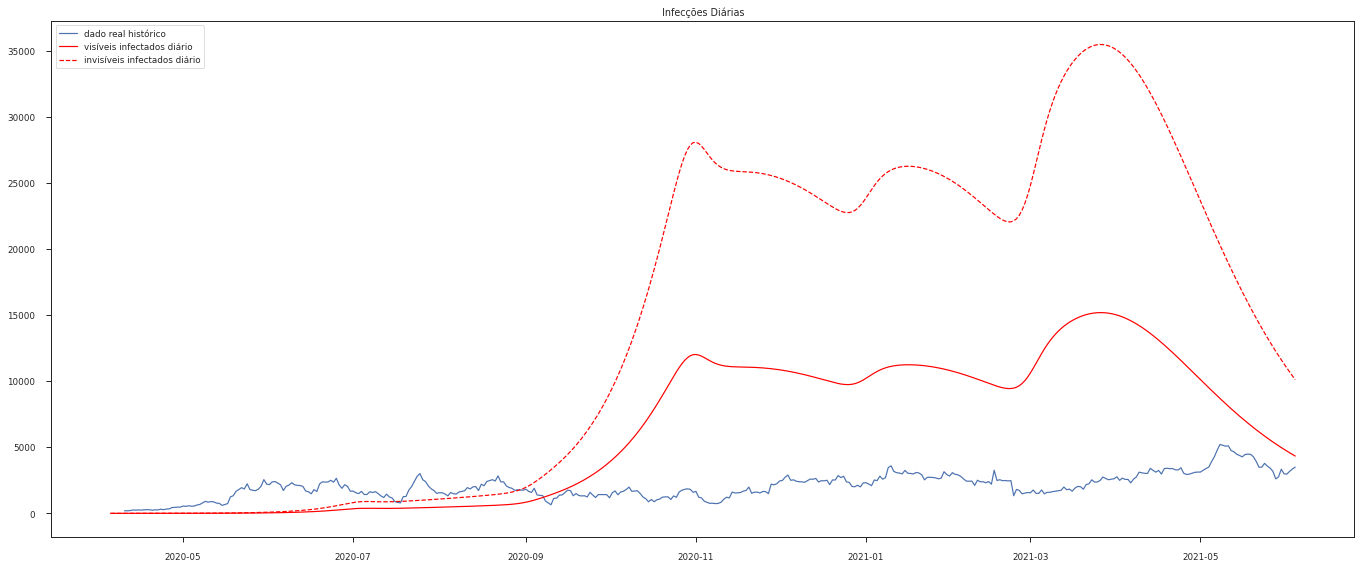

In [52]:
plt.figure(figsize=(19, 8))
plt.plot(train_subset.date, train_subset_smoothed['infectados_por_dia'], label='dado real histórico')

plt.plot(daily_df.new_infected_visible, label='visíveis infectados diário', color='red')
plt.plot(daily_df.new_infected_invisible, label='invisíveis infectados diário', color='red', linestyle='dashed')
#plt.legend()
plt.legend(loc="upper left")
plt.title('Infecções Diárias')

plt.tight_layout()
fig.autofmt_xdate()
plt.show()

# **Obtendo previsões**

In [53]:
test_t = len(train_subset) + np.arange(len(test_subset))

In [54]:
train_t, test_t

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [55]:
test_initial_conds = (S[-1], E[-1], I[-1], Iv[-1], R[-1], Rv[-1], D[-1], Dv[-1],V[-1])

In [56]:
(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv, test_V), history = model.predict(test_t, test_initial_conds)

In [57]:
(test_new_exposed,
         test_new_infected_invisible, test_new_infected_visible,
         test_new_recovered_invisible,
         test_new_recovered_visible,
         test_new_dead_invisible, test_new_dead_visible, test_new_vaccinated) = model.compute_daily_values(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv, test_V)

In [58]:
test_daily_df = pd.DataFrame(
    {
        'date': test_subset.date[1:].values,
        'new_exposed': test_new_exposed,
        'new_infected_invisible': test_new_infected_invisible,
        'new_infected_visible': test_new_infected_visible,
        'new_recovered_invisible': test_new_recovered_invisible,
        'new_recovered_visible': test_new_recovered_visible,
        'new_dead_invisible': test_new_dead_invisible,
        'new_dead_visible': test_new_dead_visible,
        'new_vaccinated' : test_new_vaccinated
    },
    index=test_subset.date[1:])

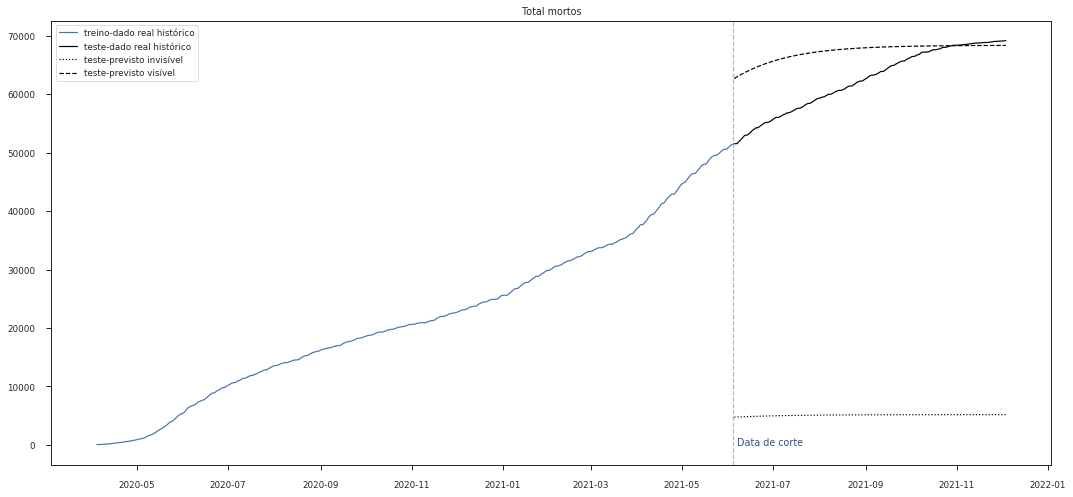

In [59]:
plt.figure(figsize=(15, 7))
plt.plot(train_subset.date, train_subset['total_mortos'], label='treino-dado real histórico')

plt.plot(test_subset.date, test_subset['total_mortos'], label='teste-dado real histórico', color='black')
plt.plot(test_subset.date, test_D, label='teste-previsto invisível', color='black', linestyle=':')
plt.plot(test_subset.date, test_Dv, label='teste-previsto visível', color='black', linestyle='dashed')
#plt.legend()
plt.legend(loc="upper left")
plt.title('Total mortos')

x_line_annotation = pd.to_datetime('2021-06-04')
x_text_annotation = x_line_annotation + pd.to_timedelta(3, unit='D')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
plt.text(x=x_text_annotation, 
         y=10, 
        s='Data de corte', 
         horizontalalignment='left',
        color='#334f8d',
        fontweight='medium')


plt.tight_layout()
fig.autofmt_xdate()
plt.show()

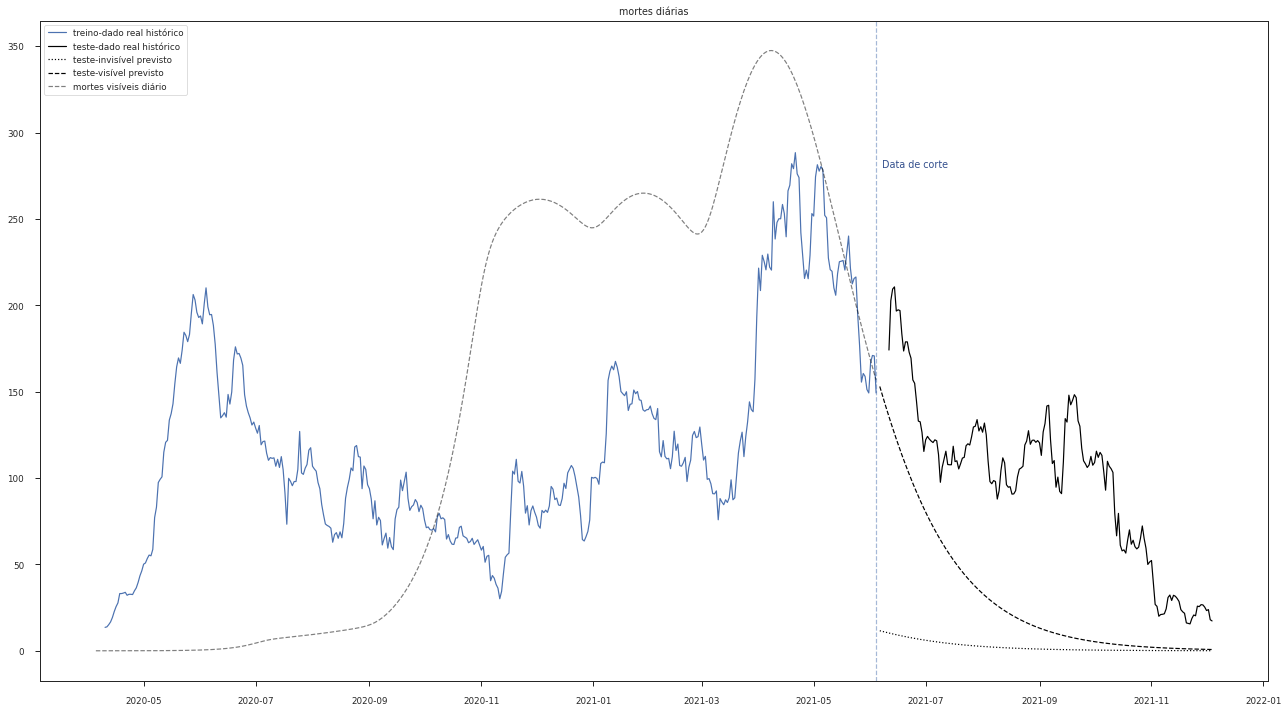

In [60]:
plt.figure(figsize=(18, 10))
# plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')
# plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset_smoothed['mortos_por_dia'], label='treino-dado real histórico')
plt.plot(test_subset.date, test_subset_smoothed['mortos_por_dia'], label='teste-dado real histórico', color='black')

plt.plot(test_daily_df.new_dead_invisible, label='teste-invisível previsto', color='black', linestyle=':')
plt.plot(test_daily_df.new_dead_visible, label='teste-visível previsto', color='black', linestyle='dashed')
plt.plot(daily_df.new_dead_visible, label='mortes visíveis diário', color='black', alpha=0.5, linestyle='dashed')
#plt.legend()
plt.legend(loc="upper left")
plt.title('mortes diárias')

x_line_annotation = pd.to_datetime('2021-06-04')
x_text_annotation = x_line_annotation + pd.to_timedelta(3, unit='D')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
plt.text(x=x_text_annotation, 
         y=280, 
        s='Data de corte', 
         horizontalalignment='left',
        color='#334f8d',
        fontweight='medium')

plt.tight_layout()
fig.autofmt_xdate()
plt.show()

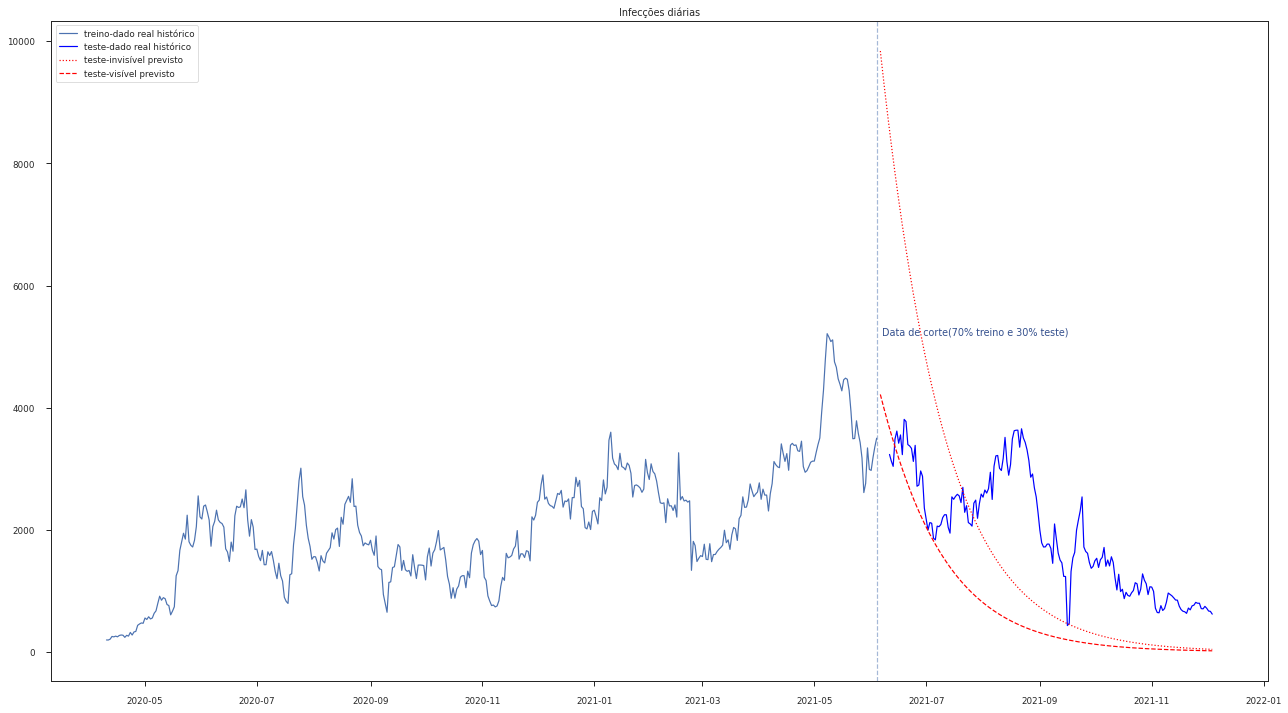

In [61]:
plt.figure(figsize=(18, 10))
plt.plot(train_subset.date, train_subset_smoothed['infectados_por_dia'], label='treino-dado real histórico')

plt.plot(test_subset.date, test_subset_smoothed['infectados_por_dia'], label='teste-dado real histórico', color='blue')
plt.plot(test_daily_df.new_infected_invisible, label='teste-invisível previsto', color='red', linestyle=':')
plt.plot(test_daily_df.new_infected_visible, label='teste-visível previsto', color='red', linestyle='dashed')
plt.legend(loc="upper left")
plt.title('Infecções diárias')

x_line_annotation = pd.to_datetime('2021-06-04')
x_text_annotation = x_line_annotation + pd.to_timedelta(3, unit='D')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
plt.text(x=x_text_annotation, 
         y=5200, 
        s='Data de corte(70% treino e 30% teste)', 
         horizontalalignment='left',
        color='#334f8d',
        fontweight='medium')

plt.tight_layout()
fig.autofmt_xdate()
plt.show()

# Avaliar modelo por validação cruzada

In [62]:
from utils import eval_on_select_dates_and_k_days_ahead, smape

In [63]:
K = 30
last_day = dfRJ.date.iloc[-1] - pd.to_timedelta(K, unit='D')
eval_dates = pd.date_range(start='2021-06-04', end=last_day)[::20]
len(eval_dates)

8

In [64]:
print(dfRJ.date.iloc[-1])

2021-12-04 00:00:00


In [65]:
print(pd.to_timedelta(K, unit='D'))

30 days 00:00:00


In [66]:
print(last_day)

2021-11-04 00:00:00


In [67]:
def eval_ID_RJ(train_df, t, train_t, eval_t):
    weights = {
        'I': 0.3,
        'R': 0.4,
        'D': 0.3,
    }
    model = SEIR_ID()
    fitter = CurveFitter_ID(
        new_deaths_col='mortos_por_dia_ma7',
        new_cases_col='infectados_por_dia_ma7',
        new_recoveries_col='recuperados_por_dia_ma7',
        weights=weights,
        max_iters=1000,
        save_params_every=500)
    fitter.fit(model, train_df)

    train_initial_conditions = model.get_initial_conditions(train_df)
    train_states, history = model.predict(train_t, train_initial_conditions, history=False)

    test_initial_conds = [compartment[-1] for compartment in train_states]
    test_states, history = model.predict(eval_t, test_initial_conds, history=False)
        
    return model, fitter, test_states

In [68]:
models, fitters, model_predictions, train_dfs, test_dfs = eval_on_select_dates_and_k_days_ahead(dfRJ,
                                                                                     eval_func=eval_ID_RJ, 
                                                                                     eval_dates=eval_dates, 
                                                                                     k=K)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed: 14.5min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 17.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 17.1min finished


In [69]:
x_dates = [tdf.date.iloc[-1] for tdf in test_dfs]

In [70]:
print(x_dates)

[Timestamp('2021-07-03 00:00:00'), Timestamp('2021-07-23 00:00:00'), Timestamp('2021-08-12 00:00:00'), Timestamp('2021-09-01 00:00:00'), Timestamp('2021-09-21 00:00:00'), Timestamp('2021-10-11 00:00:00'), Timestamp('2021-10-31 00:00:00'), Timestamp('2021-11-20 00:00:00')]


In [71]:
model_pred_D = [pred[7] for pred in model_predictions]
true_D = [tdf.total_mortos.values for tdf in test_dfs]
baseline_pred_D = [[tdf.iloc[-1].total_mortos]*K for tdf in train_dfs]

In [72]:
overall_errors_model = [mean_absolute_error(true, pred) for true, pred in zip(true_D, model_pred_D)]
overall_errors_baseline = [mean_absolute_error(true, pred) for true, pred in zip(true_D, baseline_pred_D)]
overall_smape_model = [smape(true, pred) for true, pred in zip(true_D, model_pred_D)]

# *Error Baseline/Model/Smape*

In [73]:
print('Mean overall error baseline', np.mean(overall_errors_baseline).round(3))
print('Mean overall error model', np.mean(overall_errors_model).round(3))
print('Mean overall smape model', np.mean(overall_smape_model).round(3))

Mean overall error baseline 1675.654
Mean overall error model 4647.079
Mean overall smape model 0.038


In [74]:
np.median(overall_errors_model)

2835.075993175642

In [75]:
overall_smape_model = [smape(true, pred) for true, pred in zip(true_D, model_pred_D)]
np.median(overall_smape_model)

0.02206543547275737

In [76]:
overall_errors_model

[10683.41332175471,
 2117.9560617658226,
 5994.721326877235,
 525.4150751090109,
 2367.6224603694823,
 1482.2311955145017,
 3302.529525981802,
 10702.739925525624]

In [77]:
print('MAE baseline', np.mean(overall_errors_baseline).round(3))
print('MAE model', np.mean(overall_errors_model).round(3))
print('SMAPE model', np.mean(overall_smape_model).round(3))

MAE baseline 1675.654
MAE model 4647.079
SMAPE model 0.038


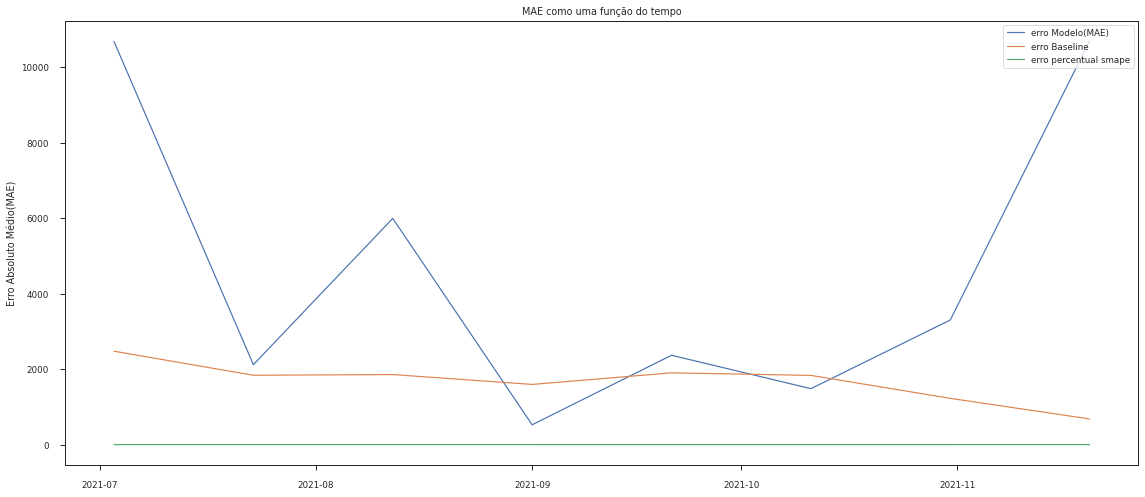

In [78]:
plt.figure(figsize=(16, 7))
plt.plot(x_dates, overall_errors_model, label='erro Modelo(MAE)')
plt.plot(x_dates, overall_errors_baseline, label='erro Baseline')
plt.plot(x_dates, overall_smape_model, label='erro percentual smape')
#plt.legend()
plt.legend(loc="upper right")
plt.ylabel('Erro Absoluto Médio(MAE)')
plt.title('MAE como uma função do tempo')

plt.tight_layout()
fig.autofmt_xdate()
plt.show()

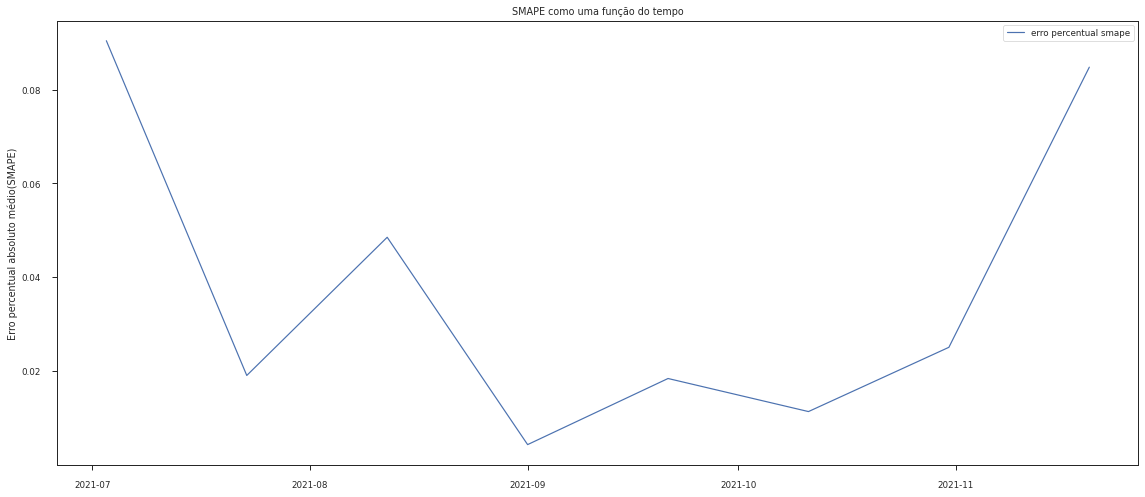

In [79]:
plt.figure(figsize=(16, 7))
#plt.plot(x_dates, overall_errors_model, label='erro Modelo')
#plt.plot(x_dates, overall_errors_baseline, label='erro Baseline')
plt.plot(x_dates, overall_smape_model, label='erro percentual smape')
#plt.legend()
plt.legend(loc="upper right")
plt.ylabel('Erro percentual absoluto médio(SMAPE)')
plt.title('SMAPE como uma função do tempo')

plt.tight_layout()
fig.autofmt_xdate()
plt.show()

**Observando um previsão**

In [80]:
result = fitter.result
result

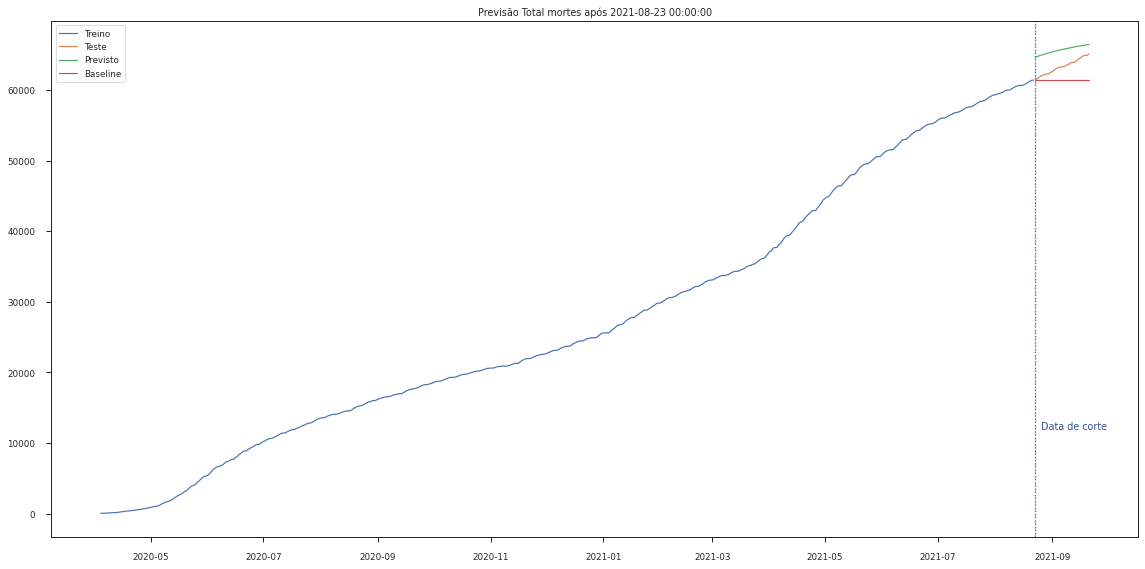

In [81]:
ix = np.random.choice(np.arange(len(train_dfs[-5:])))

train_df = train_dfs[ix]
test_df = test_dfs[ix]
model_preds = model_predictions[ix]
baseline_predictions = baseline_pred_D[ix]
fitter = fitters[ix]
plt.figure(figsize=(16, 8))
plt.plot(train_df.date, train_df.total_mortos, label='Treino')
plt.plot(test_df.date, test_df.total_mortos, label='Teste')
plt.plot(test_df.date, model_preds[7], label='Previsto')
plt.plot(test_df.date, baseline_predictions, label='Baseline')
#
plt.legend()
plt.title(f'Previsão Total mortes após {test_df.date.iloc[0]}')
plt.axvline(x=test_df.date.iloc[0], linestyle='dotted', label='data de corte')


x_line_annotation = pd.to_datetime(test_df.date.iloc[0])
x_text_annotation = x_line_annotation + pd.to_timedelta(3, unit='D')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
plt.text(x=x_text_annotation, 
         y=12000, 
        s='Data de corte', 
         horizontalalignment='left',
        color='#334f8d',
        fontweight='medium')




plt.tight_layout()

fig.autofmt_xdate()
plt.show()

**Simulando previsão com Prophet**

In [ ]:
from fbprophet import Prophet

In [ ]:
dfRJ2 = dfRJ[['date','total_mortos']]


In [ ]:
#dfRJ2 = dfRJ2.sort_values(by=['mortos_por_dia'], ascending=True)

In [ ]:
dfRJ2.head()

,date,total_mortos
2020-04-04,2020-04-04,58
2020-04-05,2020-04-05,64
2020-04-06,2020-04-06,71
2020-04-07,2020-04-07,89
2020-04-08,2020-04-08,106


In [ ]:
mortes = dfRJ2.reset_index(drop=True)

In [ ]:
mortes.head()

,date,total_mortos
0,2020-04-04,58
1,2020-04-05,64
2,2020-04-06,71
3,2020-04-07,89
4,2020-04-08,106


In [ ]:
mortes.columns = ['ds','y']

In [ ]:
mortes.tail()

,ds,y
605,2021-11-30,69061
606,2021-12-01,69082
607,2021-12-02,69102
608,2021-12-03,69124
609,2021-12-04,69132


In [ ]:
dias = 30

In [ ]:
m = Prophet(interval_width=0.95)
m.fit(mortes)
futuro = m.make_future_dataframe(periods=dias)
futuro.tail(dias)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
610,2021-12-05
611,2021-12-06
612,2021-12-07
613,2021-12-08
614,2021-12-09
615,2021-12-10
616,2021-12-11
617,2021-12-12
618,2021-12-13
619,2021-12-14


In [ ]:
previsao = m.predict(futuro)

In [ ]:
previsao[['ds', 'yhat_lower', 'yhat', 'yhat_upper']].tail(dias)

,ds,yhat_lower,yhat,yhat_upper
610,2021-12-05,70204.457173,70925.488524,71638.559103
611,2021-12-06,70196.289523,70924.408241,71679.343665
612,2021-12-07,70317.025055,71043.429652,71714.346675
613,2021-12-08,70443.569313,71162.396091,71849.464262
614,2021-12-09,70595.213630,71293.984628,71994.620200
615,2021-12-10,70661.104539,71400.528955,72129.066578
616,2021-12-11,70773.678402,71501.918927,72217.152933
617,2021-12-12,70876.380532,71533.204315,72265.925720
618,2021-12-13,70797.833995,71532.124032,72274.066269
619,2021-12-14,70937.721066,71651.145443,72381.214062


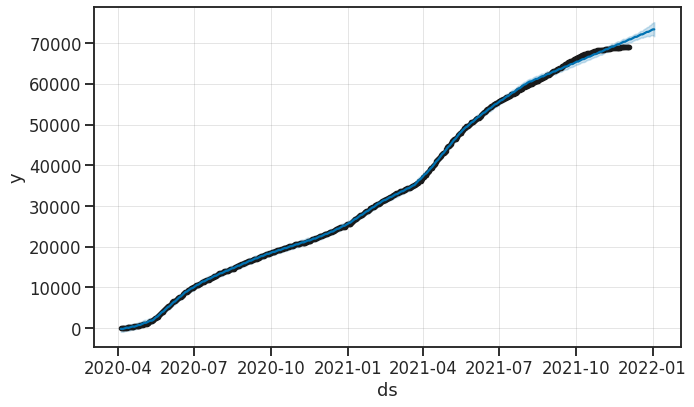

In [ ]:
confirmed_forecast_plot = m.plot(previsao)

obs: rodar o prophet com dataset até junho/20 e prever 30 dias após, comparar com nosso modelo. (acima vemos que chegamos acima de 16mil mortos após junho/20)

In [ ]:
print(ix)

3


# Gráficos/Curvas Plot 

In [82]:
sns.set_context("paper")
sns.set_style("ticks")

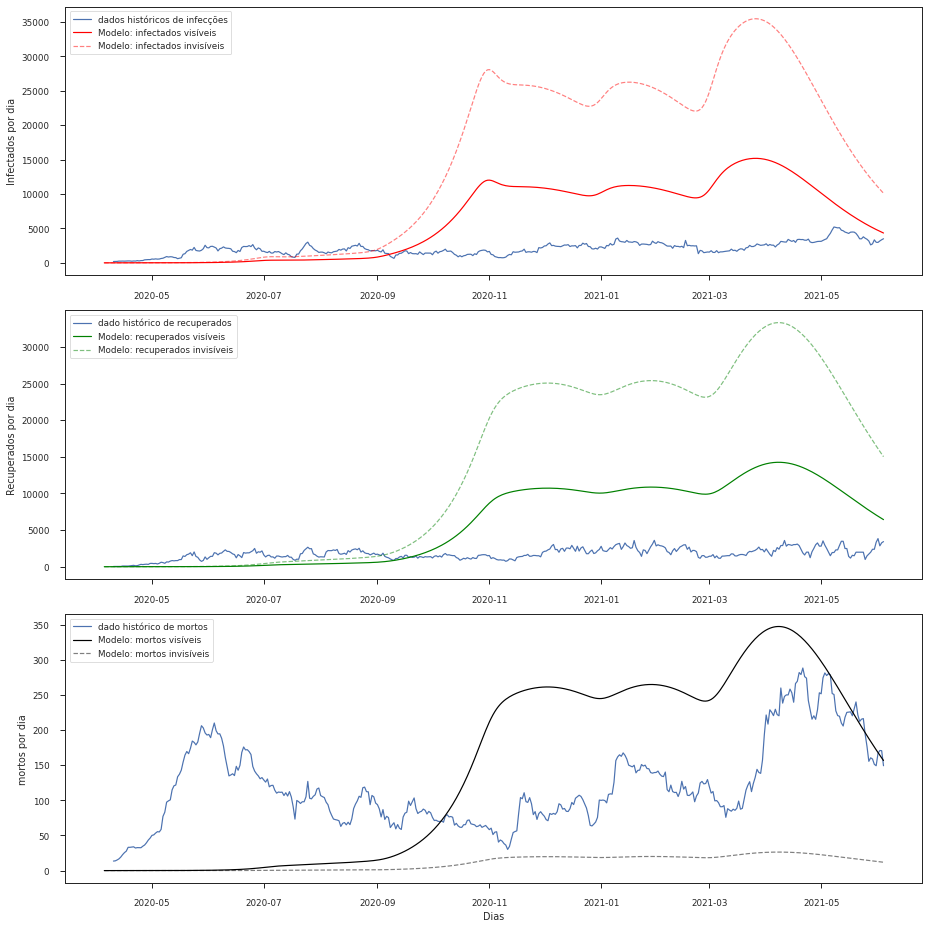

In [83]:
plt.figure(figsize=(13, 13))

ax1 = plt.subplot(3, 1, 1)
plt.plot(train_subset.date, train_subset_smoothed['infectados_por_dia'], label='dados históricos de infecções')
plt.plot(daily_df.new_infected_visible, label='Modelo: infectados visíveis', color='red', )
plt.plot(daily_df.new_infected_invisible, label='Modelo: infectados invisíveis', color='red', alpha=0.5, linestyle='dashed')
plt.legend(loc="upper left")
plt.ylabel('Infectados por dia')
#plt.xlim(pd.to_datetime('2021-04-06'), pd.to_datetime('2022-02-06'))

plt.subplot(3, 1, 2, sharex=ax1)
plt.plot(train_subset.date, train_subset_smoothed['recuperados_por_dia'], label='dado histórico de recuperados')
plt.plot(daily_df.new_recovered_visible, label='Modelo: recuperados visíveis', color='green', )
plt.plot(daily_df.new_recovered_invisible, label='Modelo: recuperados invisíveis', color='green', alpha=0.5, linestyle='dashed')
plt.legend(loc="upper left")
plt.ylabel('Recuperados por dia')
#plt.xlim(pd.to_datetime('2021-04-06'), pd.to_datetime('2022-02-06'))

plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(train_subset.date, train_subset_smoothed['mortos_por_dia'], label='dado histórico de mortos')
plt.plot(daily_df.new_dead_visible, label='Modelo: mortos visíveis', color='black', )
plt.plot(daily_df.new_dead_invisible, label='Modelo: mortos invisíveis', color='black', alpha=0.5, linestyle='dashed')
plt.legend(loc="upper left")
plt.ylabel('mortos por dia')
#plt.xlim(pd.to_datetime('2021-04-06'), pd.to_datetime('2022-02-06'))
plt.xlabel('Dias')

plt.tight_layout()
#plt.savefig('figures/paper/daily_infected_dead_recovered_train.png')
plt.show()

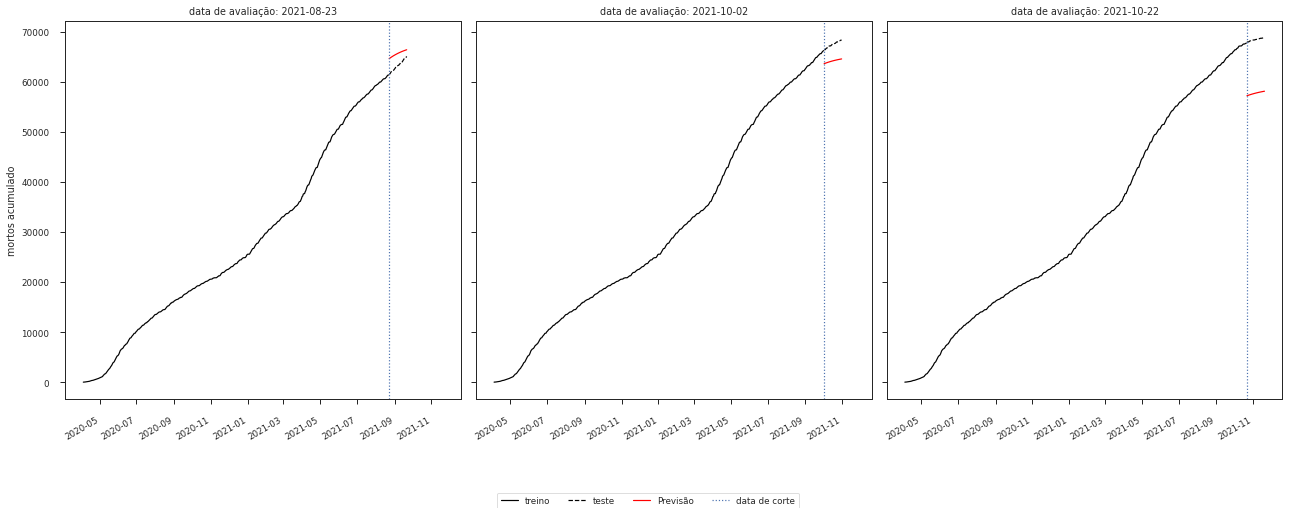

In [84]:
def plot_eval_result(ix, first=False):
    eval_date = eval_dates[ix]
    train_df = train_dfs[ix]
    test_df = test_dfs[ix]
    model_preds = model_predictions[ix]

    plt.plot(train_df.date, train_df.total_mortos, label='treino', color='black')
    plt.plot(test_df.date, test_df.total_mortos, label='teste', color='black', linestyle='dashed')
    plt.plot(test_df.date, model_preds[7], label='Previsão', color='red')
    plt.title(f'data de avaliação: {str(eval_date.date())}')
    plt.axvline(x=eval_date, linestyle='dotted', label='data de corte')
    if first:
        plt.ylabel('mortos acumulado')
    else:
        plt.setp(plt.gca().get_yticklabels(), visible=False)

fig = plt.figure(figsize=(18, 7))

ax1 = plt.subplot(1, 3, 1)
ix = 4
plot_eval_result(ix, first=True)


plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ix = 6
plot_eval_result(ix)


ax3 = plt.subplot(1, 3, 3, sharex=ax1, sharey=ax1)
ix = 7
plot_eval_result(ix)

handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.01), ncol=4)
plt.tight_layout()

fig.autofmt_xdate()

#plt.savefig('figures/paper/model_testing_results.png')
plt.show()

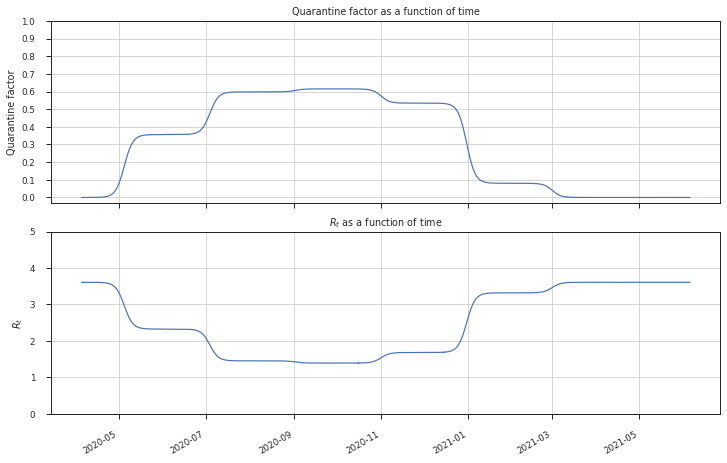

In [93]:
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, Iv, R, Rv, D, Dv), history = model.predict(train_t, train_initial_conditions)
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)

history_dates = dfRJ.date.iloc[0] + pd.to_timedelta(history.t, unit='days')

fig = plt.figure(figsize=(10, 7))
ax1 = plt.subplot(2,1,1)
plt.plot(history_dates, history.quarantine_mult, label='Quarantine factor')
plt.tight_layout()
y_ticks = list(np.arange(0, 1.1, 0.1).round(1))
plt.gca().set_yticks(y_ticks)
plt.ylabel("Quarantine factor")
plt.title("Quarantine factor as a function of time")
plt.grid()

plt.subplot(2,1,2, sharex=ax1)
plt.plot(history_dates, history.rt, label='$R_t$')
plt.ylim(0, 5)
plt.ylabel("$R_t$")
plt.grid()
plt.title("$R_t$ as a function of time")

fig.autofmt_xdate()
#plt.savefig('figures/paper/quarantine_function.png')
plt.show()

In [ ]:
#sns.set_context("talk")
#sns.set_style("ticks")